# The joint model for Navy CHARM: A3SS



In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-03-29 15:04:08.874239
Simons Foundation, Rusty HPC, worker3015


In [2]:
%cd /mnt/home/zzhang/ceph/jemm
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/jemm


In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import JemmLinearRegression, JemmLinearMixedModel
from jemm.plots import facet_boxplot
from jemm.covariate import Contrasts, Covariate

In [4]:
import pickle
import numpy as np
import pandas as pd
import os
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
plt.style.use(['science', 'no-latex', 'ieee'])


EVENT_TYPE = 'A3SS'
DATA_VER = 'data-V7'
FORCE_RERUN = False
FDR_THRESH = 0.05
PCS_TO_INCL = '0,6'
# Model method to use
USE_RE = True
MIN_RE_VAR = 0.001
%run ./notebook/navy_utils.py $DATA_VER $PCS_TO_INCL $USE_RE

Jemm = JemmLinearMixedModel if USE_RE is True else JemmLinearRegression

OUTDIR = './%s/joint_%s/' % (DATA_VER, EVENT_TYPE)
os.makedirs(OUTDIR, exist_ok=True)

FIGDIR = './%s/joint_%s/figs' % (DATA_VER, EVENT_TYPE)
os.makedirs(FIGDIR, exist_ok=True)


USE_ANNOT = True
DUMP_REDUCED = False

navy_utils.py data-V7 ['PC0', 'PC6'] True


In [5]:
JCT = pickle.load(open("./%s/compiled/jct_%s.pkl" % (DATA_VER, EVENT_TYPE), "rb"))
TXR = pickle.load(open("./%s/compiled/txr_%s.pkl" % (DATA_VER, EVENT_TYPE), "rb"))


In [6]:
from jemm.genomic_annotation import ExonSet
#exonset = ExonSet.from_rmats("./data/rmats/fromGTF.%s.txt"%EVENT_TYPE, event_type=EVENT_TYPE)
exonset = ExonSet.from_suppa("/mnt/ceph/users/zzhang/SUPPA/index/hg38/suppa_gencodev34_%s_strict.ioe"%EVENT_TYPE, 
                             cache_dir='./data/',
                             event_type=EVENT_TYPE)
if USE_ANNOT:
    exonset.read_coding_region_from_gtf_by_splice_site('/mnt/home/zzhang/ceph/genome_annotation/gencode.v34.annotation.gtf')
    exonset.read_pfam_domain_from_bed_by_splice_site('./data/hg38_exon_pfam_annot.bed.gz', 
                                                     clan_annot_fp='./data/Pfam-A.clans.tsv.gz')
    exonset.read_rbp_clip([
        './data/encode_eclip/hg38_gencodev34.all_splice_sites.encodeIDR.bed',
        './data/encode_eclip/hg38_gencodev34.all_splice_sites.clipdb.bed'
        ])

reloaded 'jemm.genemap.pkl' from cache dir ./data/


## 1. Black-list exons with training effects

In [7]:
# need to black-list the training effect exons
from jemm.covariate import Contrasts, Covariate
contrasts = Contrasts(name="final", levels=['Control'])
cov_ctrl = Covariate(fp="./%s/charm_master.clean_w_10pc.csv" % DATA_VER, sep=",", index_col=0,
                     contrasts=contrasts,
                     main_effects=['Sex', 'tp', 'pid'] + PCS_TO_INCL if USE_RE is True \
                         else ['Sex', 'tp'] + PCS_TO_INCL,
                     interaction_effects=['Sex|tp'],
                     verbose=True
                     )
print("CTRL formula: %s" % cov_ctrl.formula)
jem_ctrl = Jemm(
    junction_measure=JCT, 
    transcript_measure=TXR, 
    covariates=cov_ctrl,
    diff_intercept_by_measure=True,
    group_varname='pid',
    min_groupvar=MIN_RE_VAR,
    optimizer='lbfgs'
)

ctrl_fp = os.path.join(OUTDIR, "joint.black-list.%s.reg_table.tsv" % EVENT_TYPE)
if FORCE_RERUN is False and os.path.isfile(ctrl_fp):
    # reload the results if previous results found
    jem_ctrl.load_regression_table(outfp=ctrl_fp)
else:
    _ = jem_ctrl.run_tests(test_type='Wald',
                      data="txr",
                      force_diff_intercept=False,
                      force_rerun=True,
                      pval_adjust_method="fdr",
                      nthreads=1
                      )
    jem_ctrl.save_regression_table(ctrl_fp, 
                           exonset=exonset
                           )

CTRL formula: y = Sex + tp + pid + PC0 + PC6 + Sex|tp


/mnt/ceph/users/zzhang/jemm/jemm/model.py:101: UserWarning: Input covariate matrix has condition number = 212543.83183058104 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
/mnt/ceph/users/zzhang/jemm/jemm/model.py:665: RuntimeWarning: invalid value encountered in true_divide
  chi

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


A3SS Training effect in 201/tested 15815/total 20718


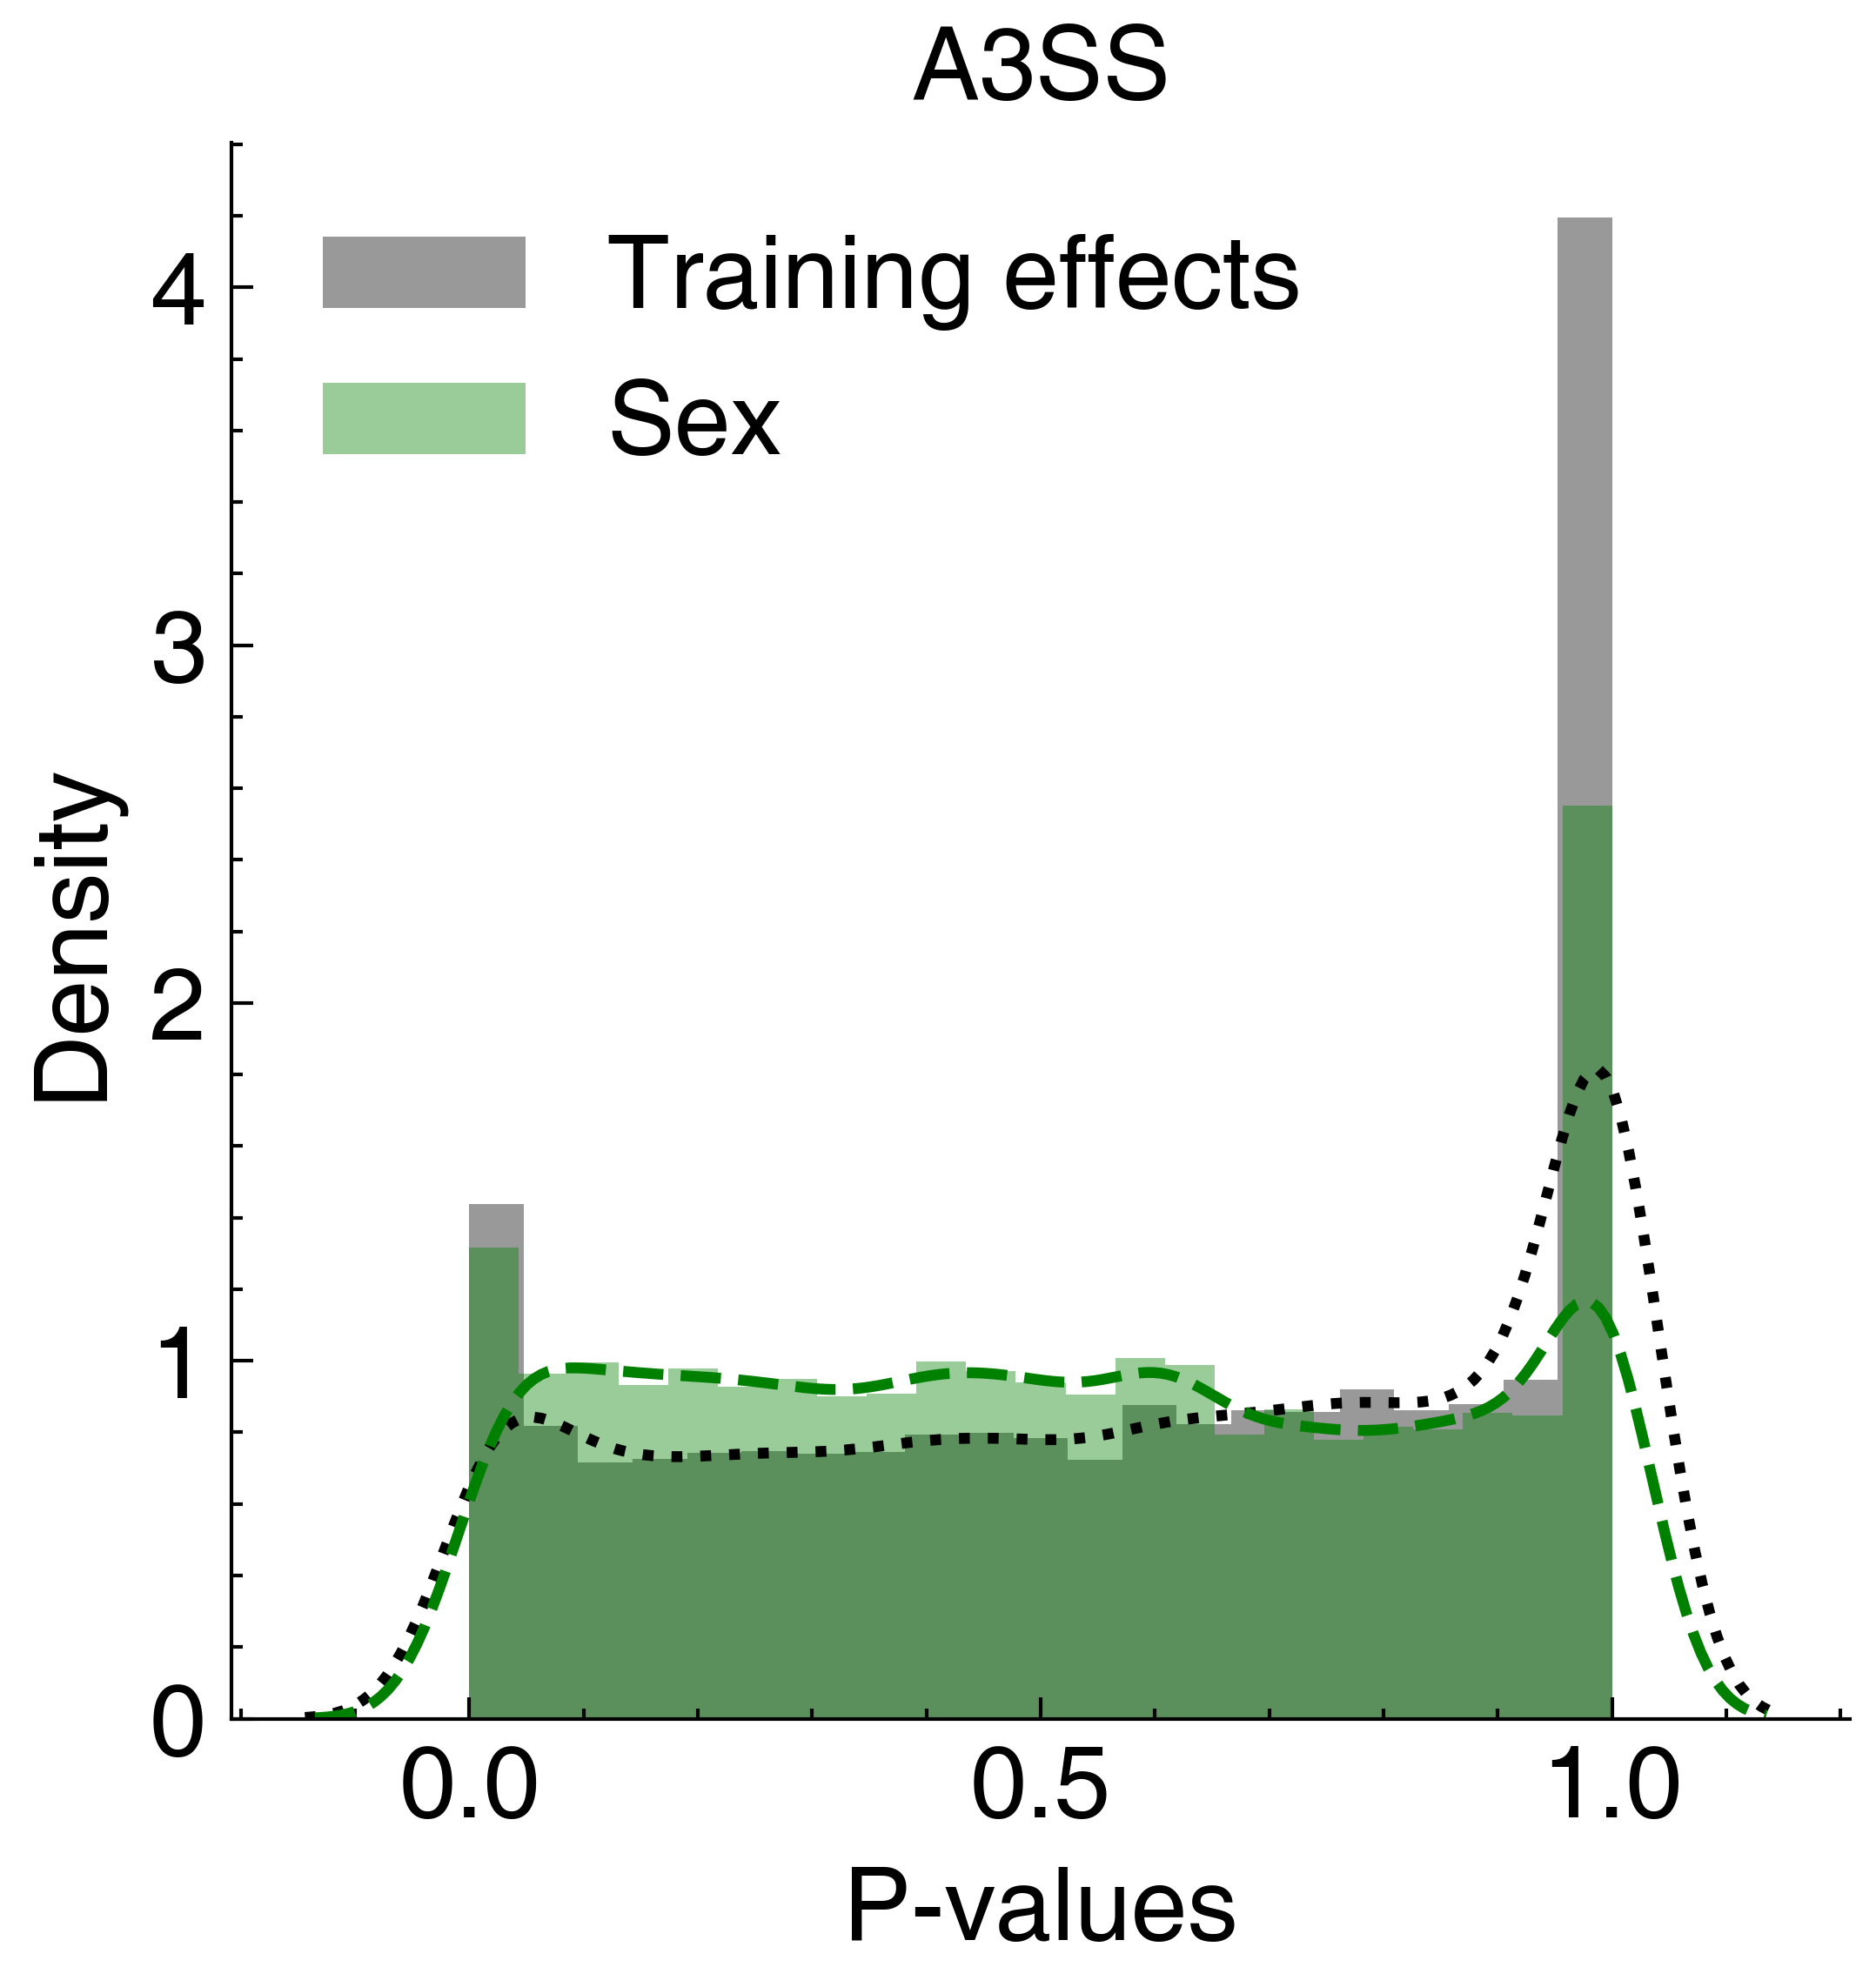

In [8]:
plt.close()
ax1 = sns.distplot(jem_ctrl.stats_sheet['tp']['pvals'], label="Training effects")
sns.distplot(jem_ctrl.stats_sheet['Sex@M']['pvals'], label="Sex", ax=ax1)
ax1.legend()
ax1.set_xlabel('P-values')
ax1.set_title("%s" % EVENT_TYPE)
plt.savefig("%s/01-train_effects.pdf" % FIGDIR)
black_list_exons = [e for e in jem_ctrl.stats_tests if 
                    jem_ctrl.stats_tests[e].loc['tp', 'qvals']<FDR_THRESH or
                    jem_ctrl.stats_tests[e].loc['Sex@M|tp', 'qvals']<FDR_THRESH
                   ]
pickle.dump(black_list_exons, open(os.path.join(OUTDIR, "black_list_exons.pkl"), "wb"))
print("%s Training effect in %i/tested %i/total %i"%(EVENT_TYPE, 
                                                     len(black_list_exons), 
                                                     len(jem_ctrl.stats_tests), 
                                                     len(jem_ctrl.event_index))
     )

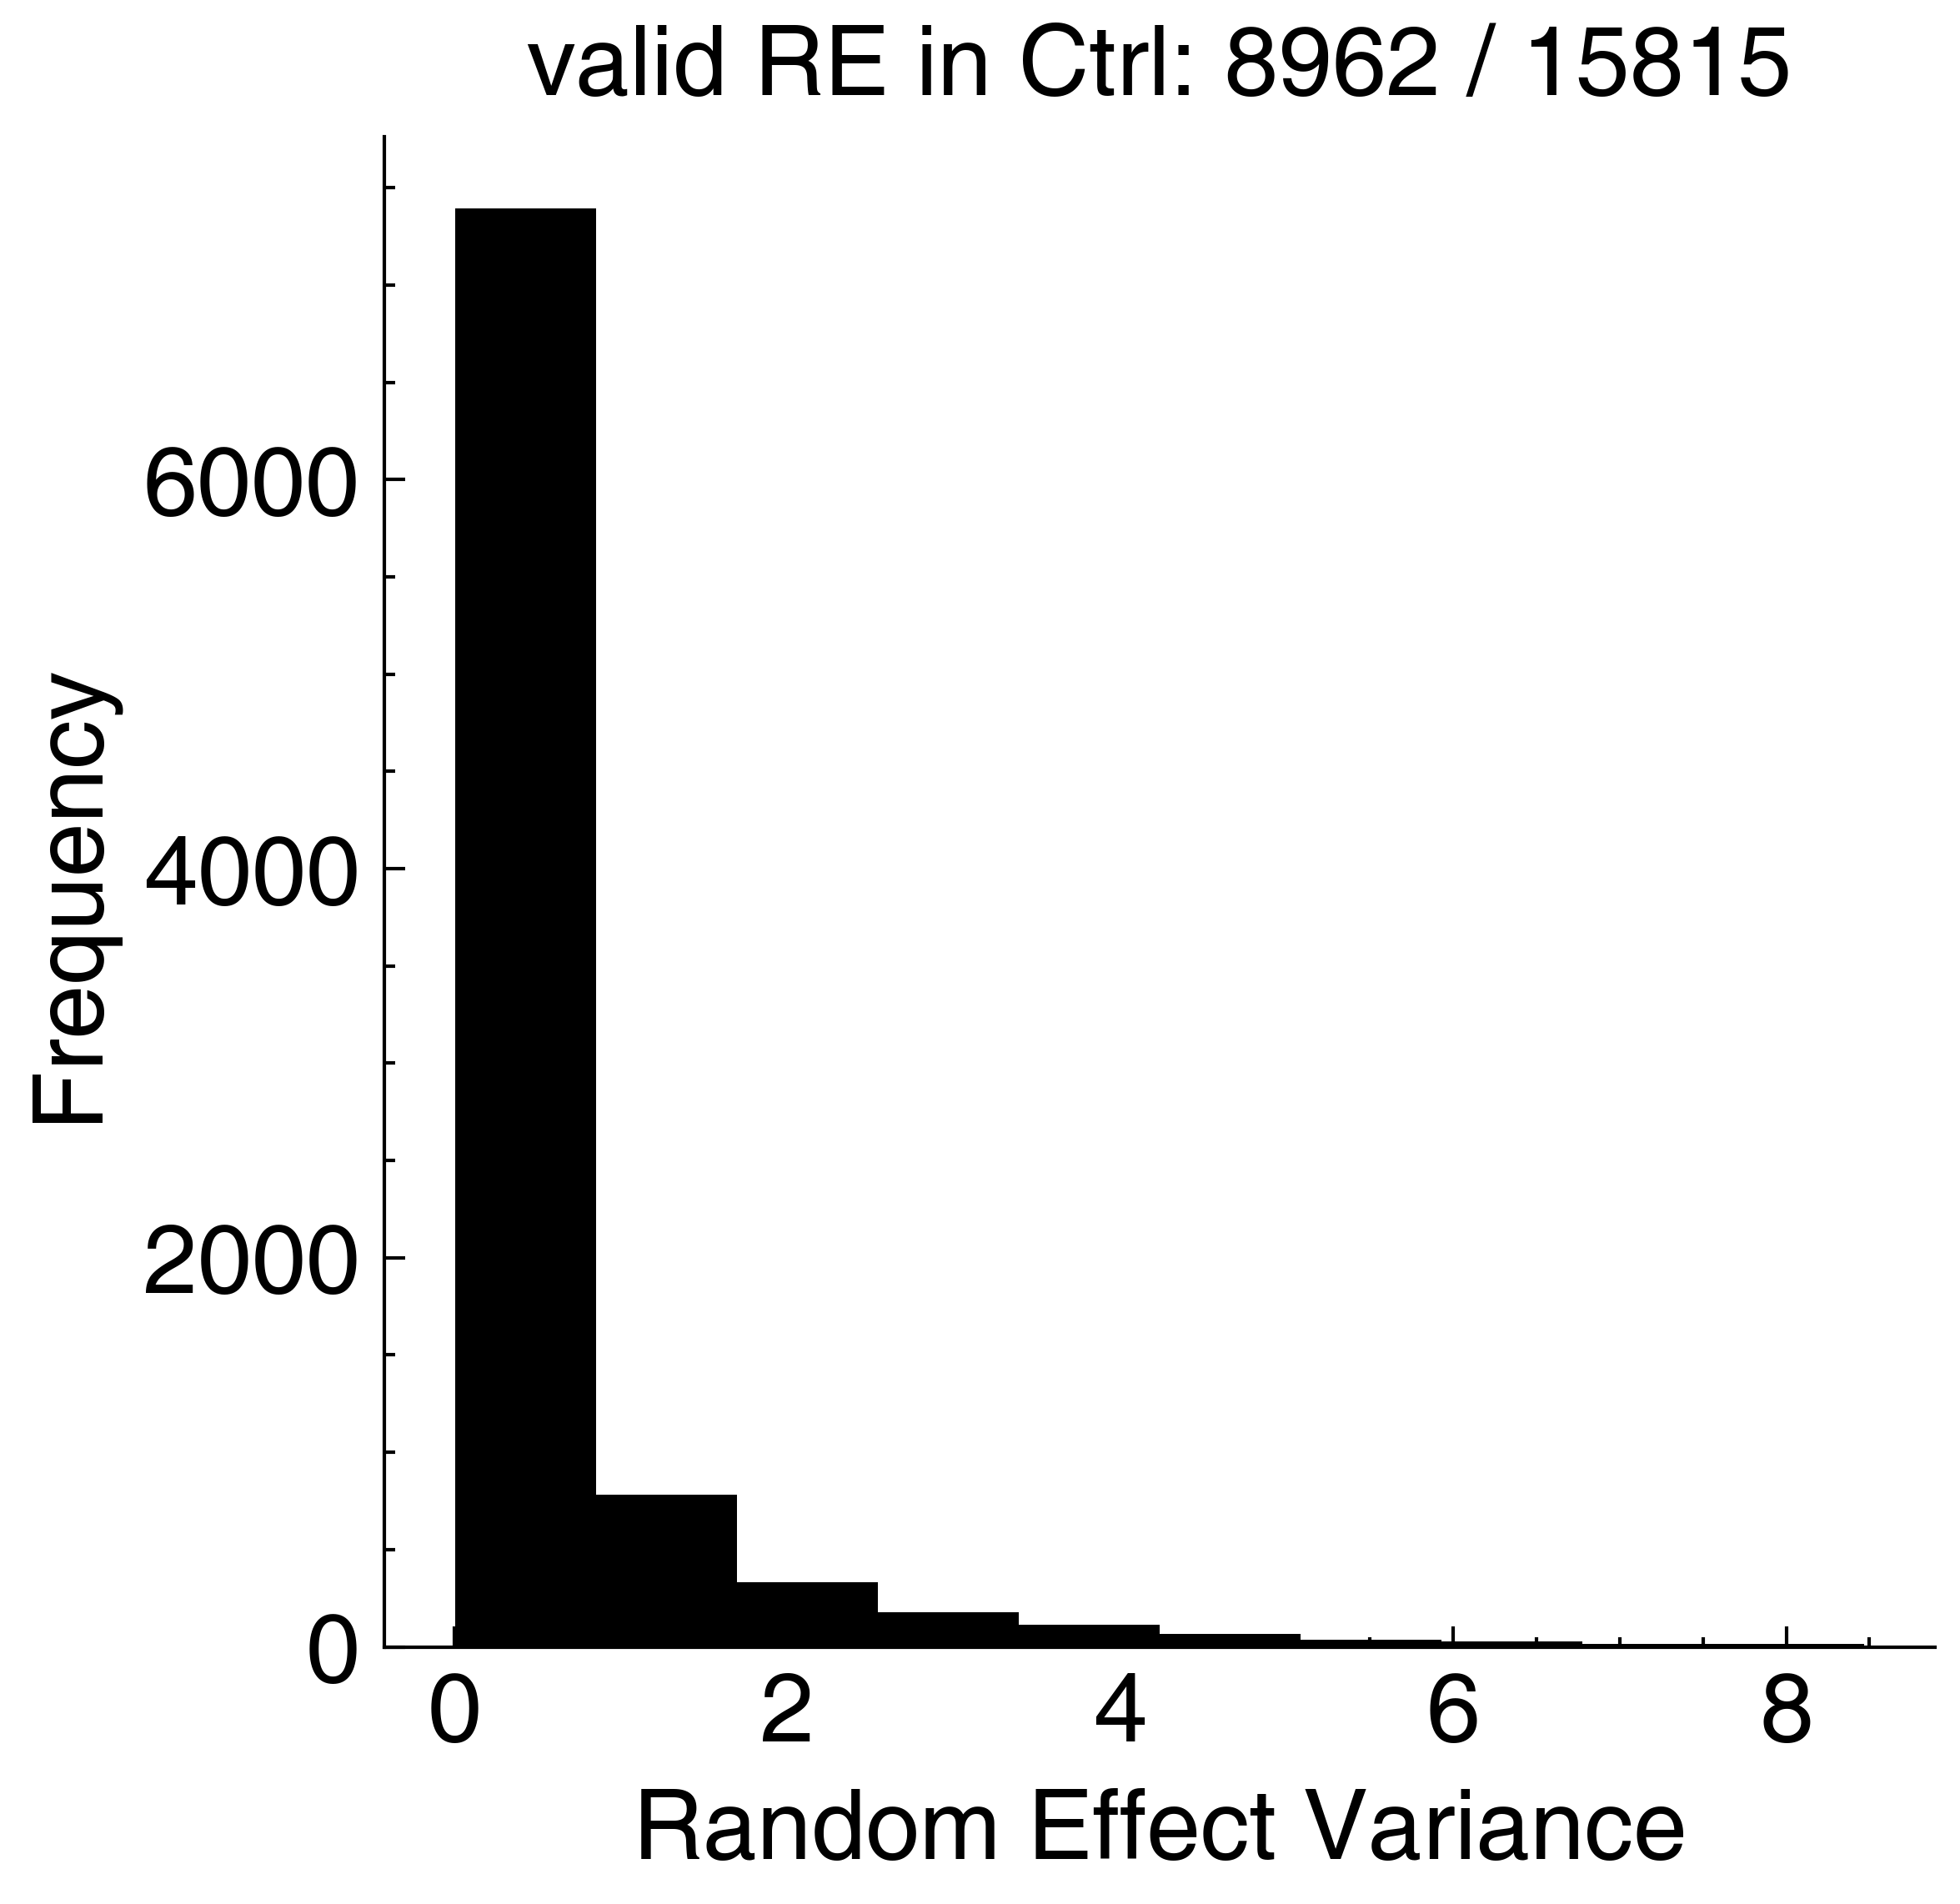

In [9]:
# What's the distribution of Random effect variance estimates?
if USE_RE:
    ax = jem_ctrl.stats_sheet['pid']['coefs'].plot(kind='hist')
    ax.set_title('valid RE in Ctrl: %i / %i' % (pd.notna(jem_ctrl.stats_sheet['pid']['coefs']).sum(), jem_ctrl.stats_sheet['pid'].shape[0]))
    ax.set_xlabel('Random Effect Variance')
    plt.savefig("%s/02-random_varcomp_ctrl.pdf" % FIGDIR)

## 2. Build joint model

In [10]:
# contrasts and covariates
print("Disease model: %s" % covs.formula)
# init jemm
jem = Jemm(junction_measure=JCT, 
           transcript_measure=TXR, 
           covariates=covs,
           diff_intercept_by_measure=True,
           group_varname='pid',
           min_groupvar=MIN_RE_VAR, 
           optimizer='lbfgs'
)
print("Before filter: %i"%len(jem.event_index))
print("Black list=%i"%len(black_list_exons))
jem.event_index = [e for e in jem.event_index if e not in black_list_exons]
print("After filter: %i"%len(jem.event_index))

Disease model: y = final + pid + Sex + PC0 + PC6
Before filter: 20718
Black list=201
After filter: 20517


/mnt/ceph/users/zzhang/jemm/jemm/model.py:101: UserWarning: Input covariate matrix has condition number = 39183.96845138911 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()


In [11]:
print('unique pids = %i' % len(jem.covariates.covariate.pid.unique()))
print('total sids = %i' % len(jem.covariates.covariate.index.unique()))

unique pids = 371
total sids = 1176


In [12]:
outfp = os.path.join(OUTDIR, "joint.%s.reg_table.tsv"%EVENT_TYPE)
if FORCE_RERUN is False and os.path.isfile(outfp):
    # reload the results if previous results found
    jem.load_regression_table(outfp=outfp)
else:
    # run tests if cannot find previous results
    _ = jem.run_tests(test_type='Wald',
                      data="txr",
                      force_diff_intercept=False,
                      force_rerun=True,
                      pval_adjust_method="fdr",
                      nthreads=1
                     )
# if new run, save the results for future re-use
jem.munge_covariates([
    'final@Pre',
    'final@First',
    'final@Mid',
    'final@Post',
],
meta_name = "final4cond"
)
reg_table = jem.save_regression_table(outfp, 
                          exonset=exonset, 
                          annotations=['coding_region', 'pfam_domain', 'rbp_clip'] if USE_ANNOT else None,
                          order_by_covariate='final4cond',
                          order_by='logP'
                         )


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [13]:
# Dump reduced version of data for later use
if DUMP_REDUCED:
    tested_eids = [e for e in jem.event_index if e in jem.stats_tests]
    jct_ = jem.junction_measure
    txr_ = jem.transcript_measure
    jct = JunctionCountTable(filepath='./%s/compiled/jct_%s.pkl'% (DATA_VER, EVENT_TYPE), 
                             input_type="plaintext", lazy_init=True)
    jct.data=jct_.loc[[e for e in tested_eids if e in jct_.index]]
    txr = TranscriptMeasureTable(lazy_init=True)
    txr.data=txr_.loc[[e for e in tested_eids if e in txr_.index]]

    import pickle
    pickle.dump(jct, open('./%s/compiled/jct_%s.reduced.pkl'% (DATA_VER, EVENT_TYPE), "wb"))
    pickle.dump(txr, open('./%s/compiled/txr_%s.reduced.pkl'% (DATA_VER, EVENT_TYPE), "wb"))

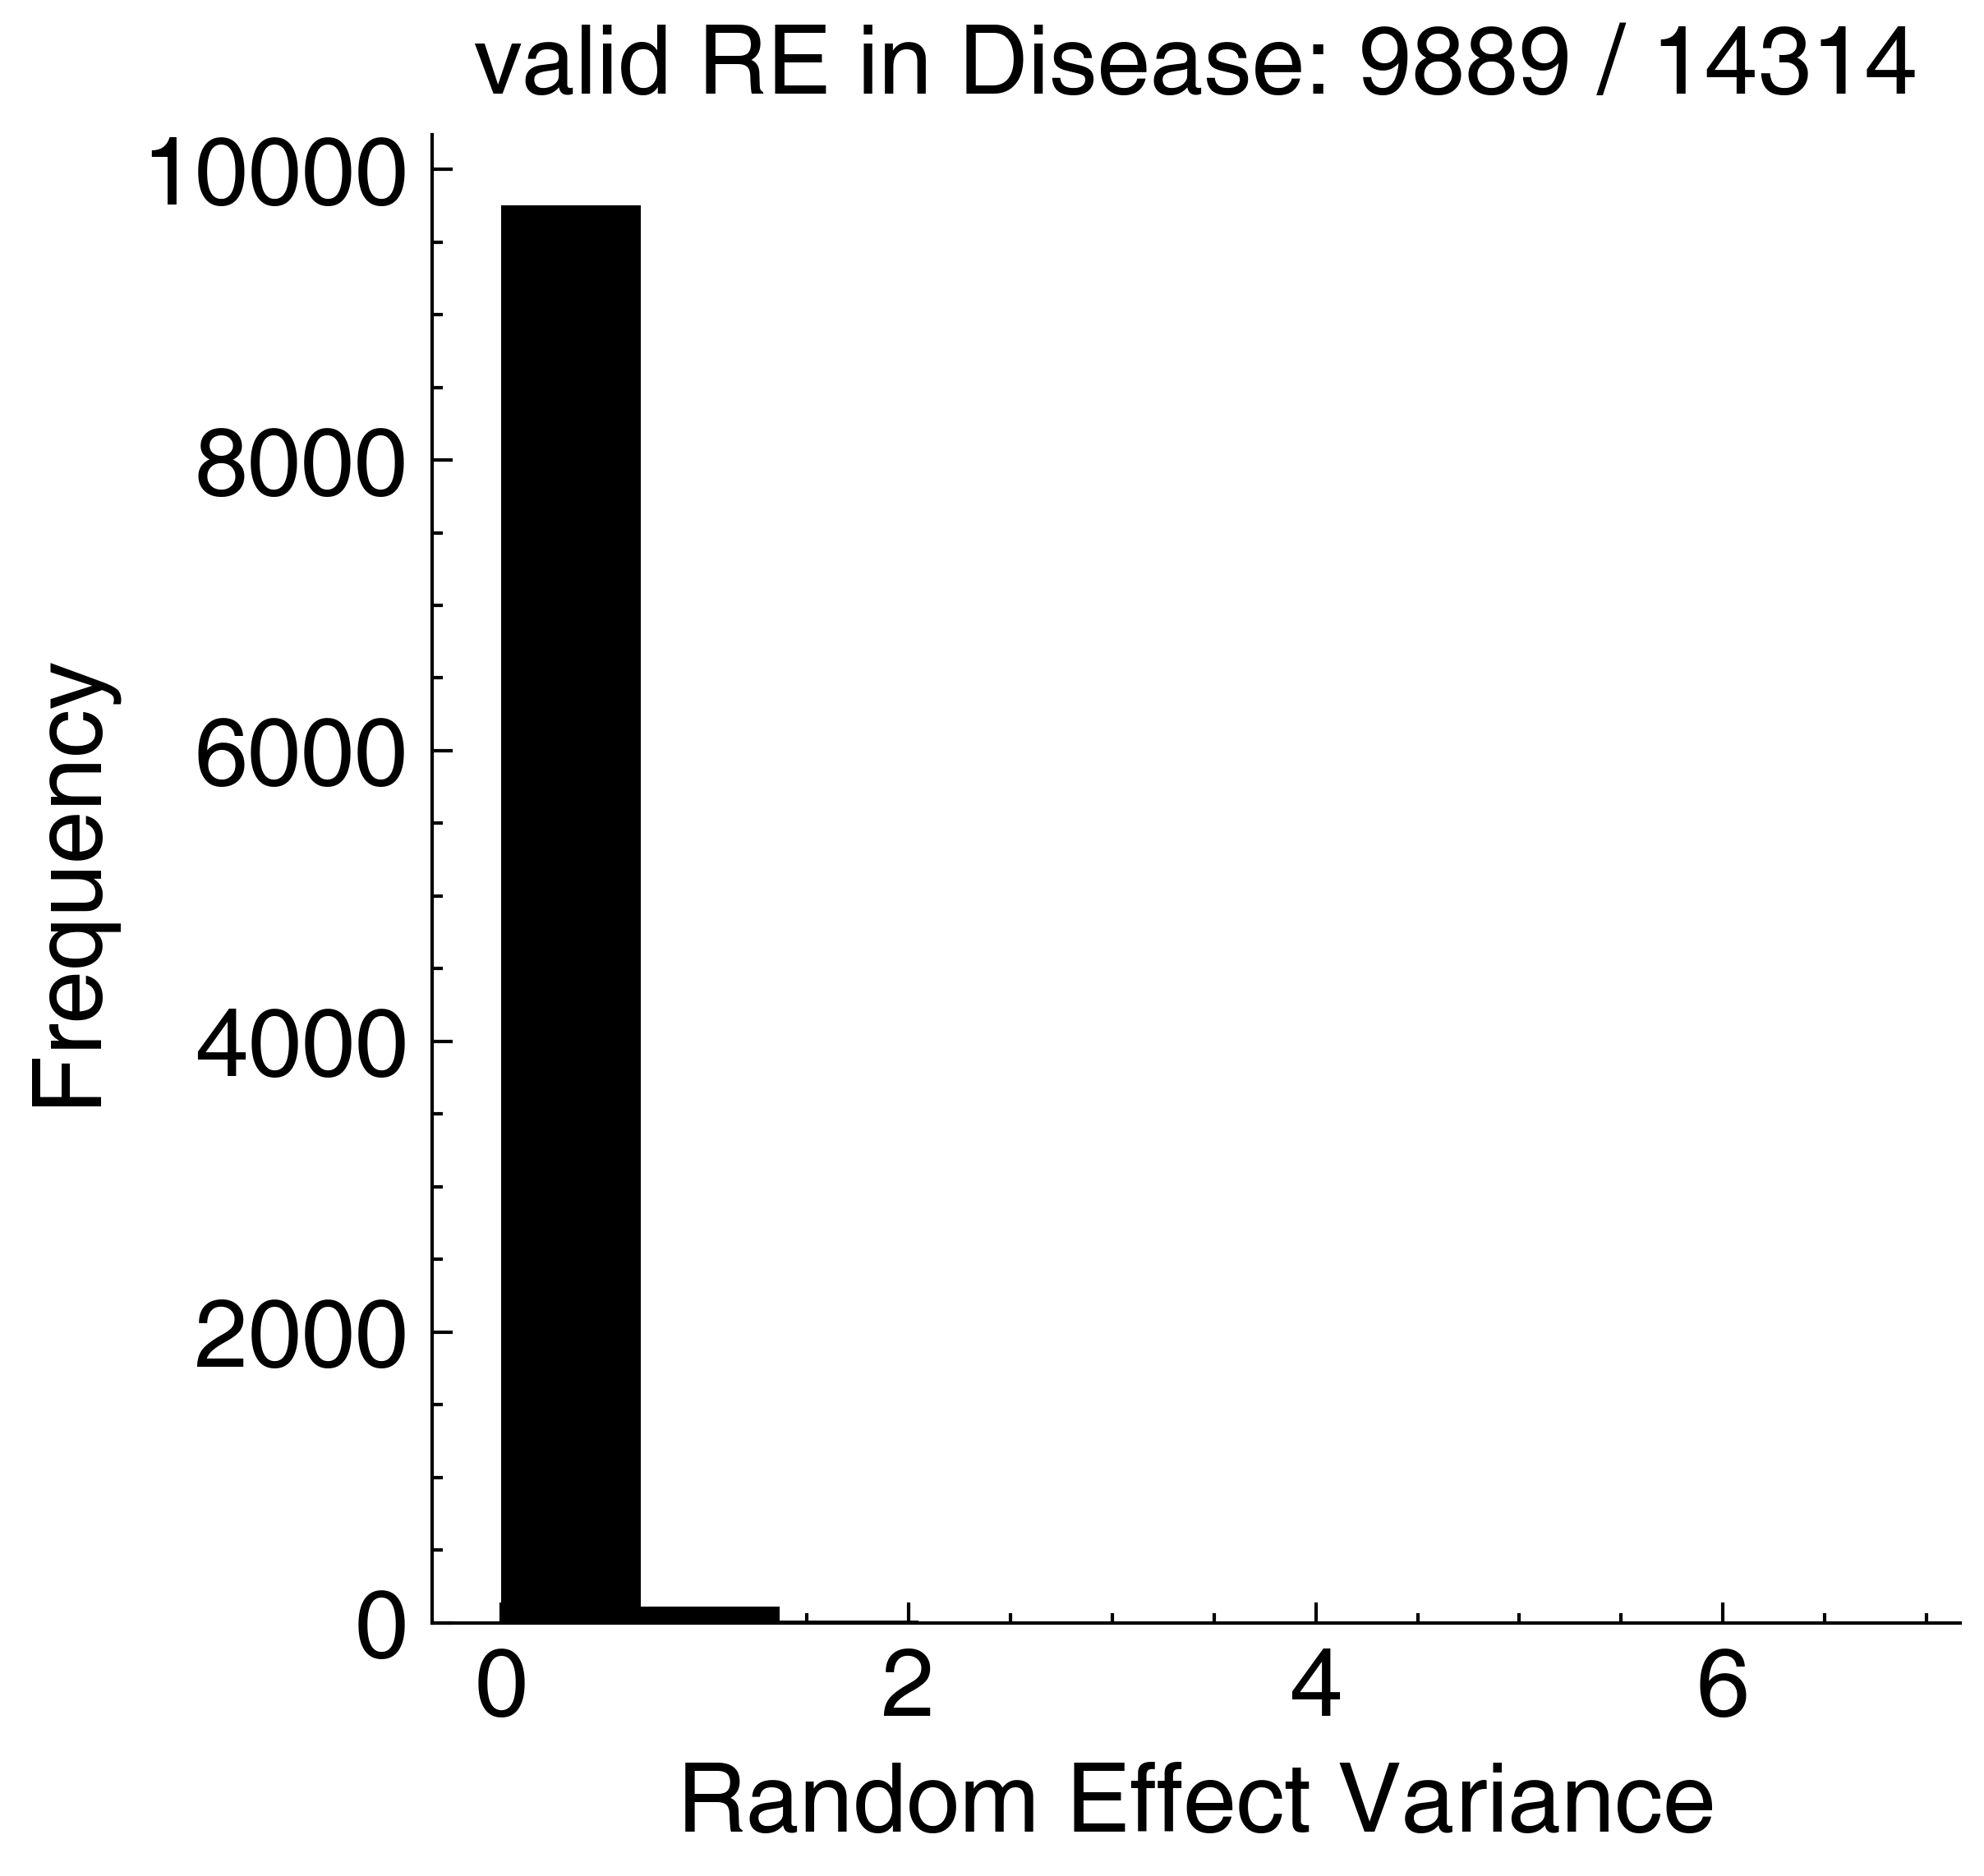

In [14]:
# What's the distribution of Random effect variance estimates?
if USE_RE:
    ax = jem.stats_sheet['pid']['coefs'].plot(kind='hist')
    ax.set_title('valid RE in Disease: %i / %i' % (pd.notna(jem.stats_sheet['pid']['coefs']).sum(), jem.stats_sheet['pid'].shape[0]))
    ax.set_xlabel('Random Effect Variance')
    plt.savefig("%s/03-random_varcomp_disease.pdf" % FIGDIR)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


A3SS, signif=309/14314
signif & abs.change=164


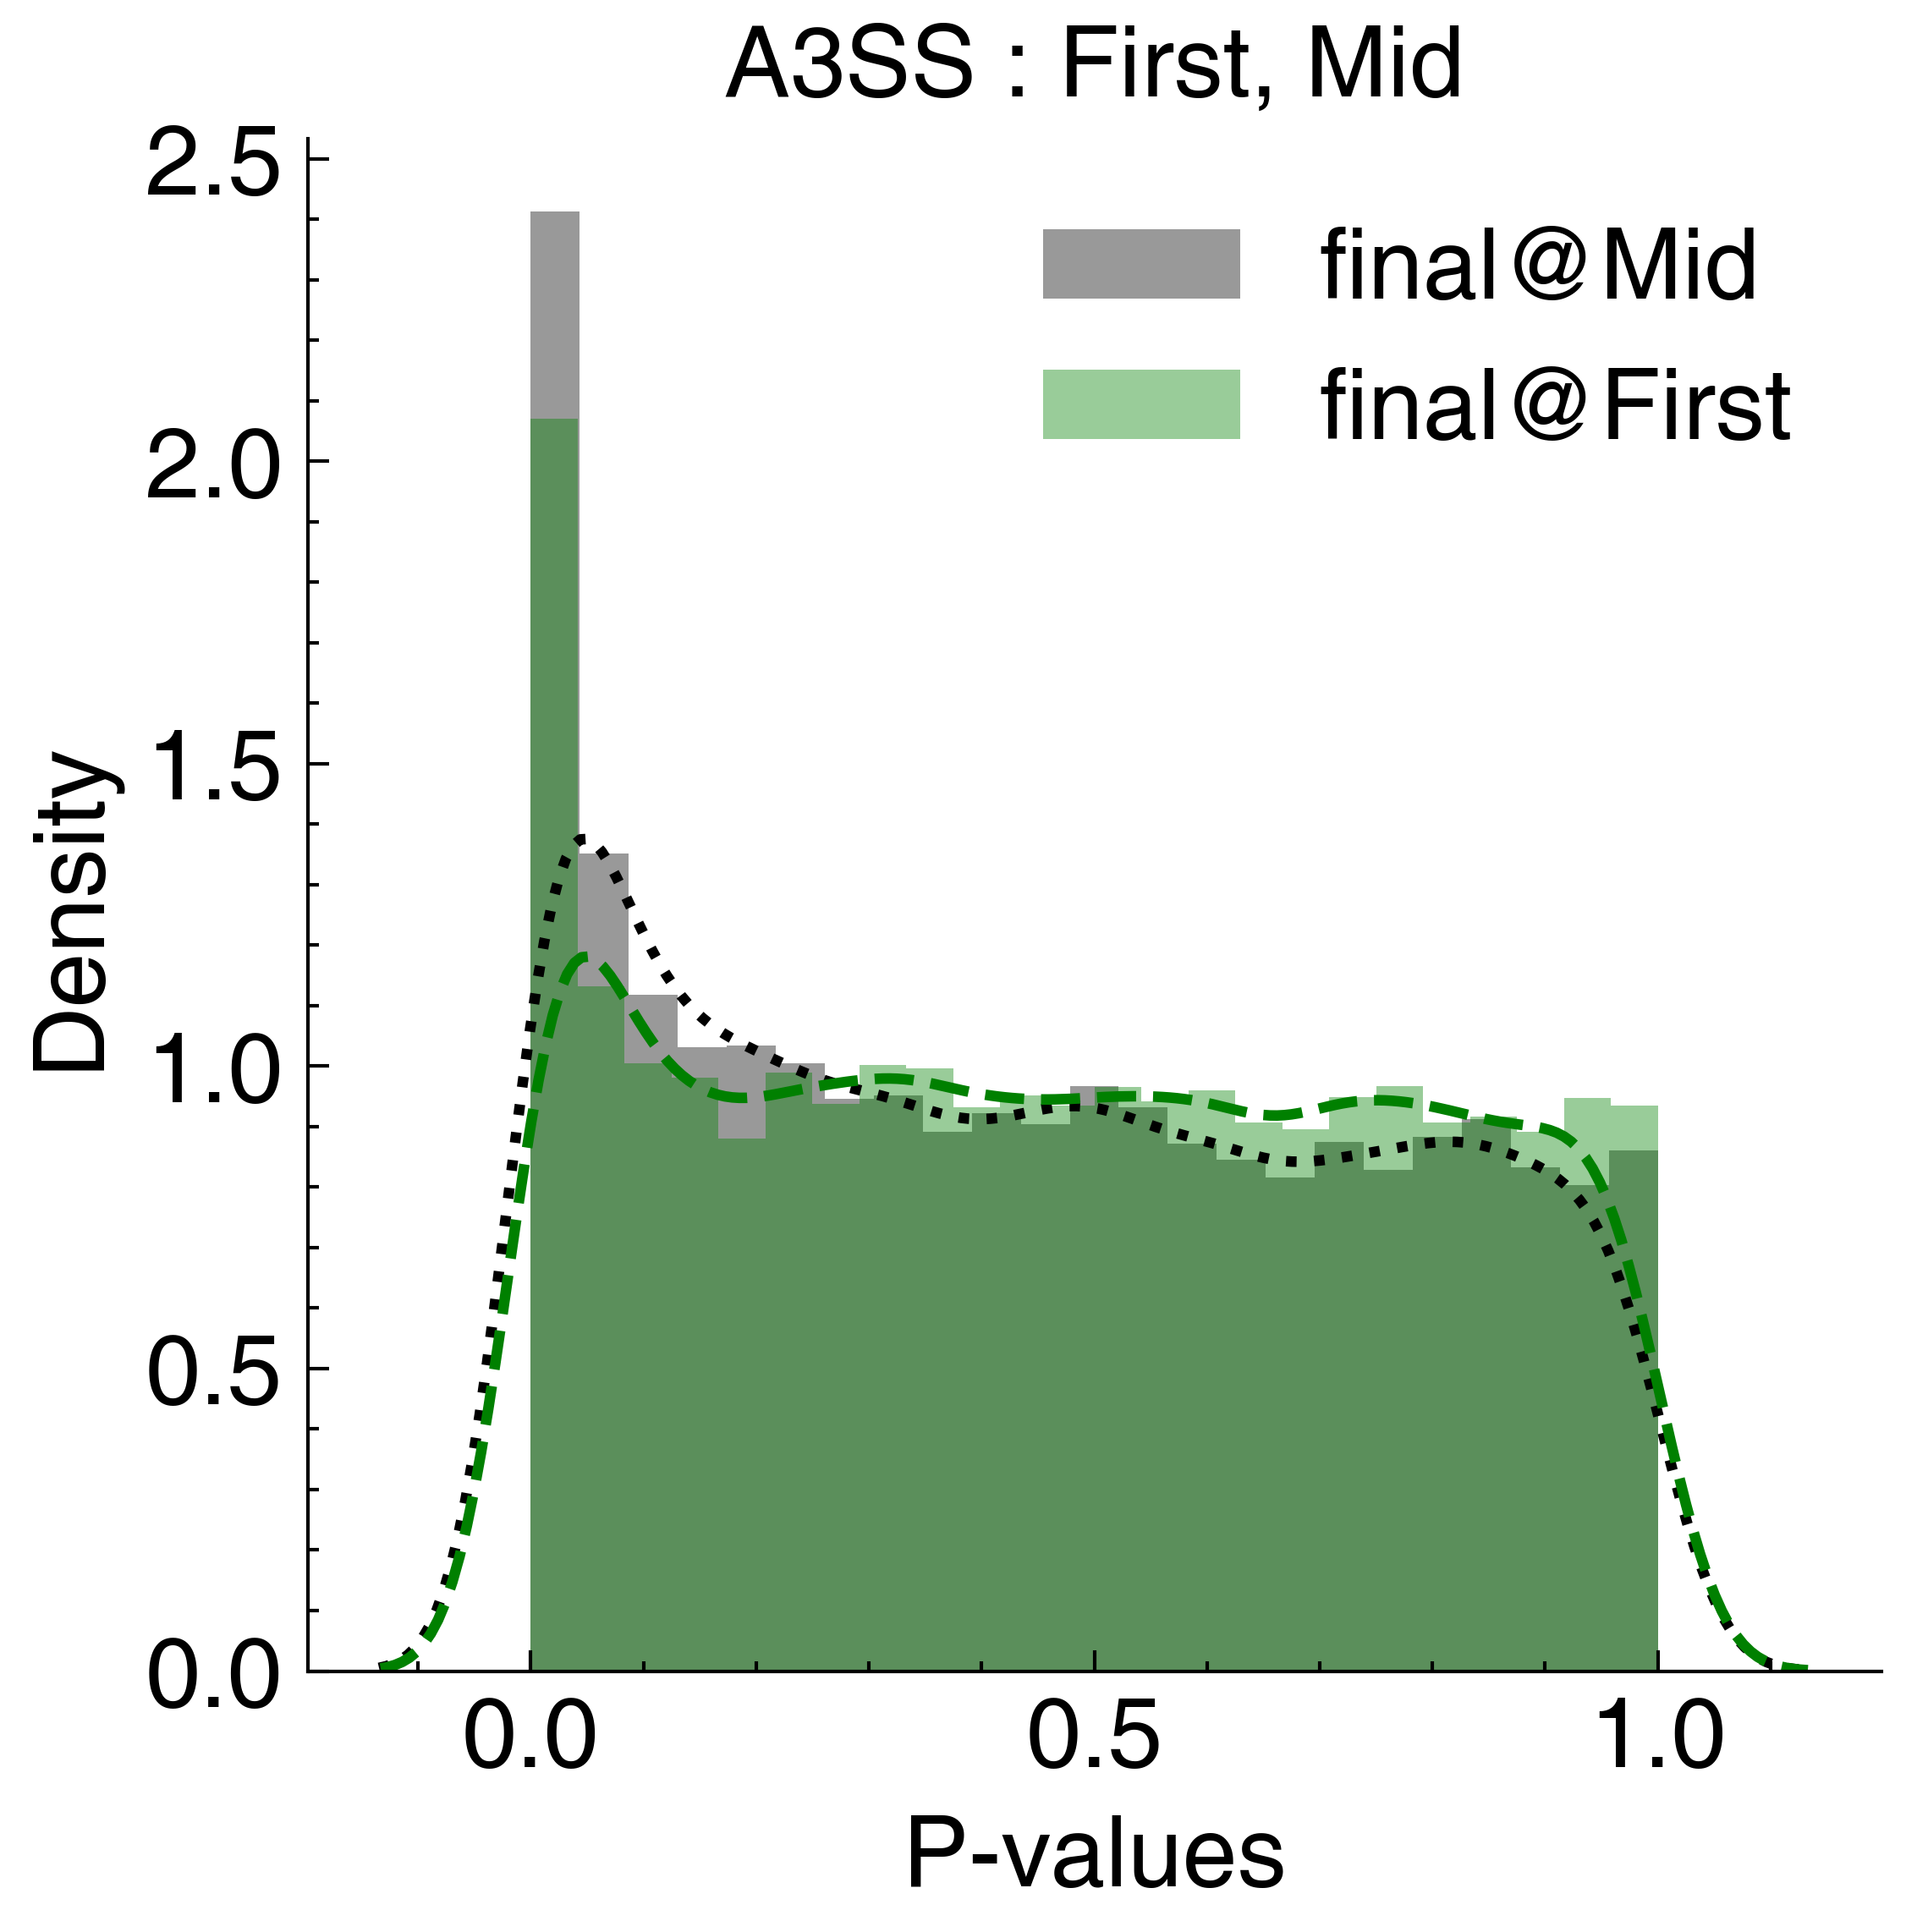

In [15]:
plt.close()
cond = 'final@Mid'
ax1 = sns.distplot(jem.stats_sheet[cond]['pvals'], label=cond)
sns.distplot(jem.stats_sheet['final@First']['pvals'], label="final@First", ax=ax1)
ax1.set_xlabel('P-values')
ax1.legend()
ax1.set_title("%s : First, Mid"%EVENT_TYPE)
plt.savefig("%s/04-pval_distr.pdf" % FIGDIR)

_eids = jem.get_stringent_candidates(contrast_col=cond, qval_thresh=FDR_THRESH, min_change=0.01,
                                         is_consistent_measure=False)
_eids = list(set(_eids))
print("%s, signif=%i/%i"%(EVENT_TYPE, 
    np.sum((
     jem.stats_sheet[cond]['qvals'] < FDR_THRESH)),
     len(jem.stats_tests))
)

print("signif & abs.change=%i" % len(_eids))

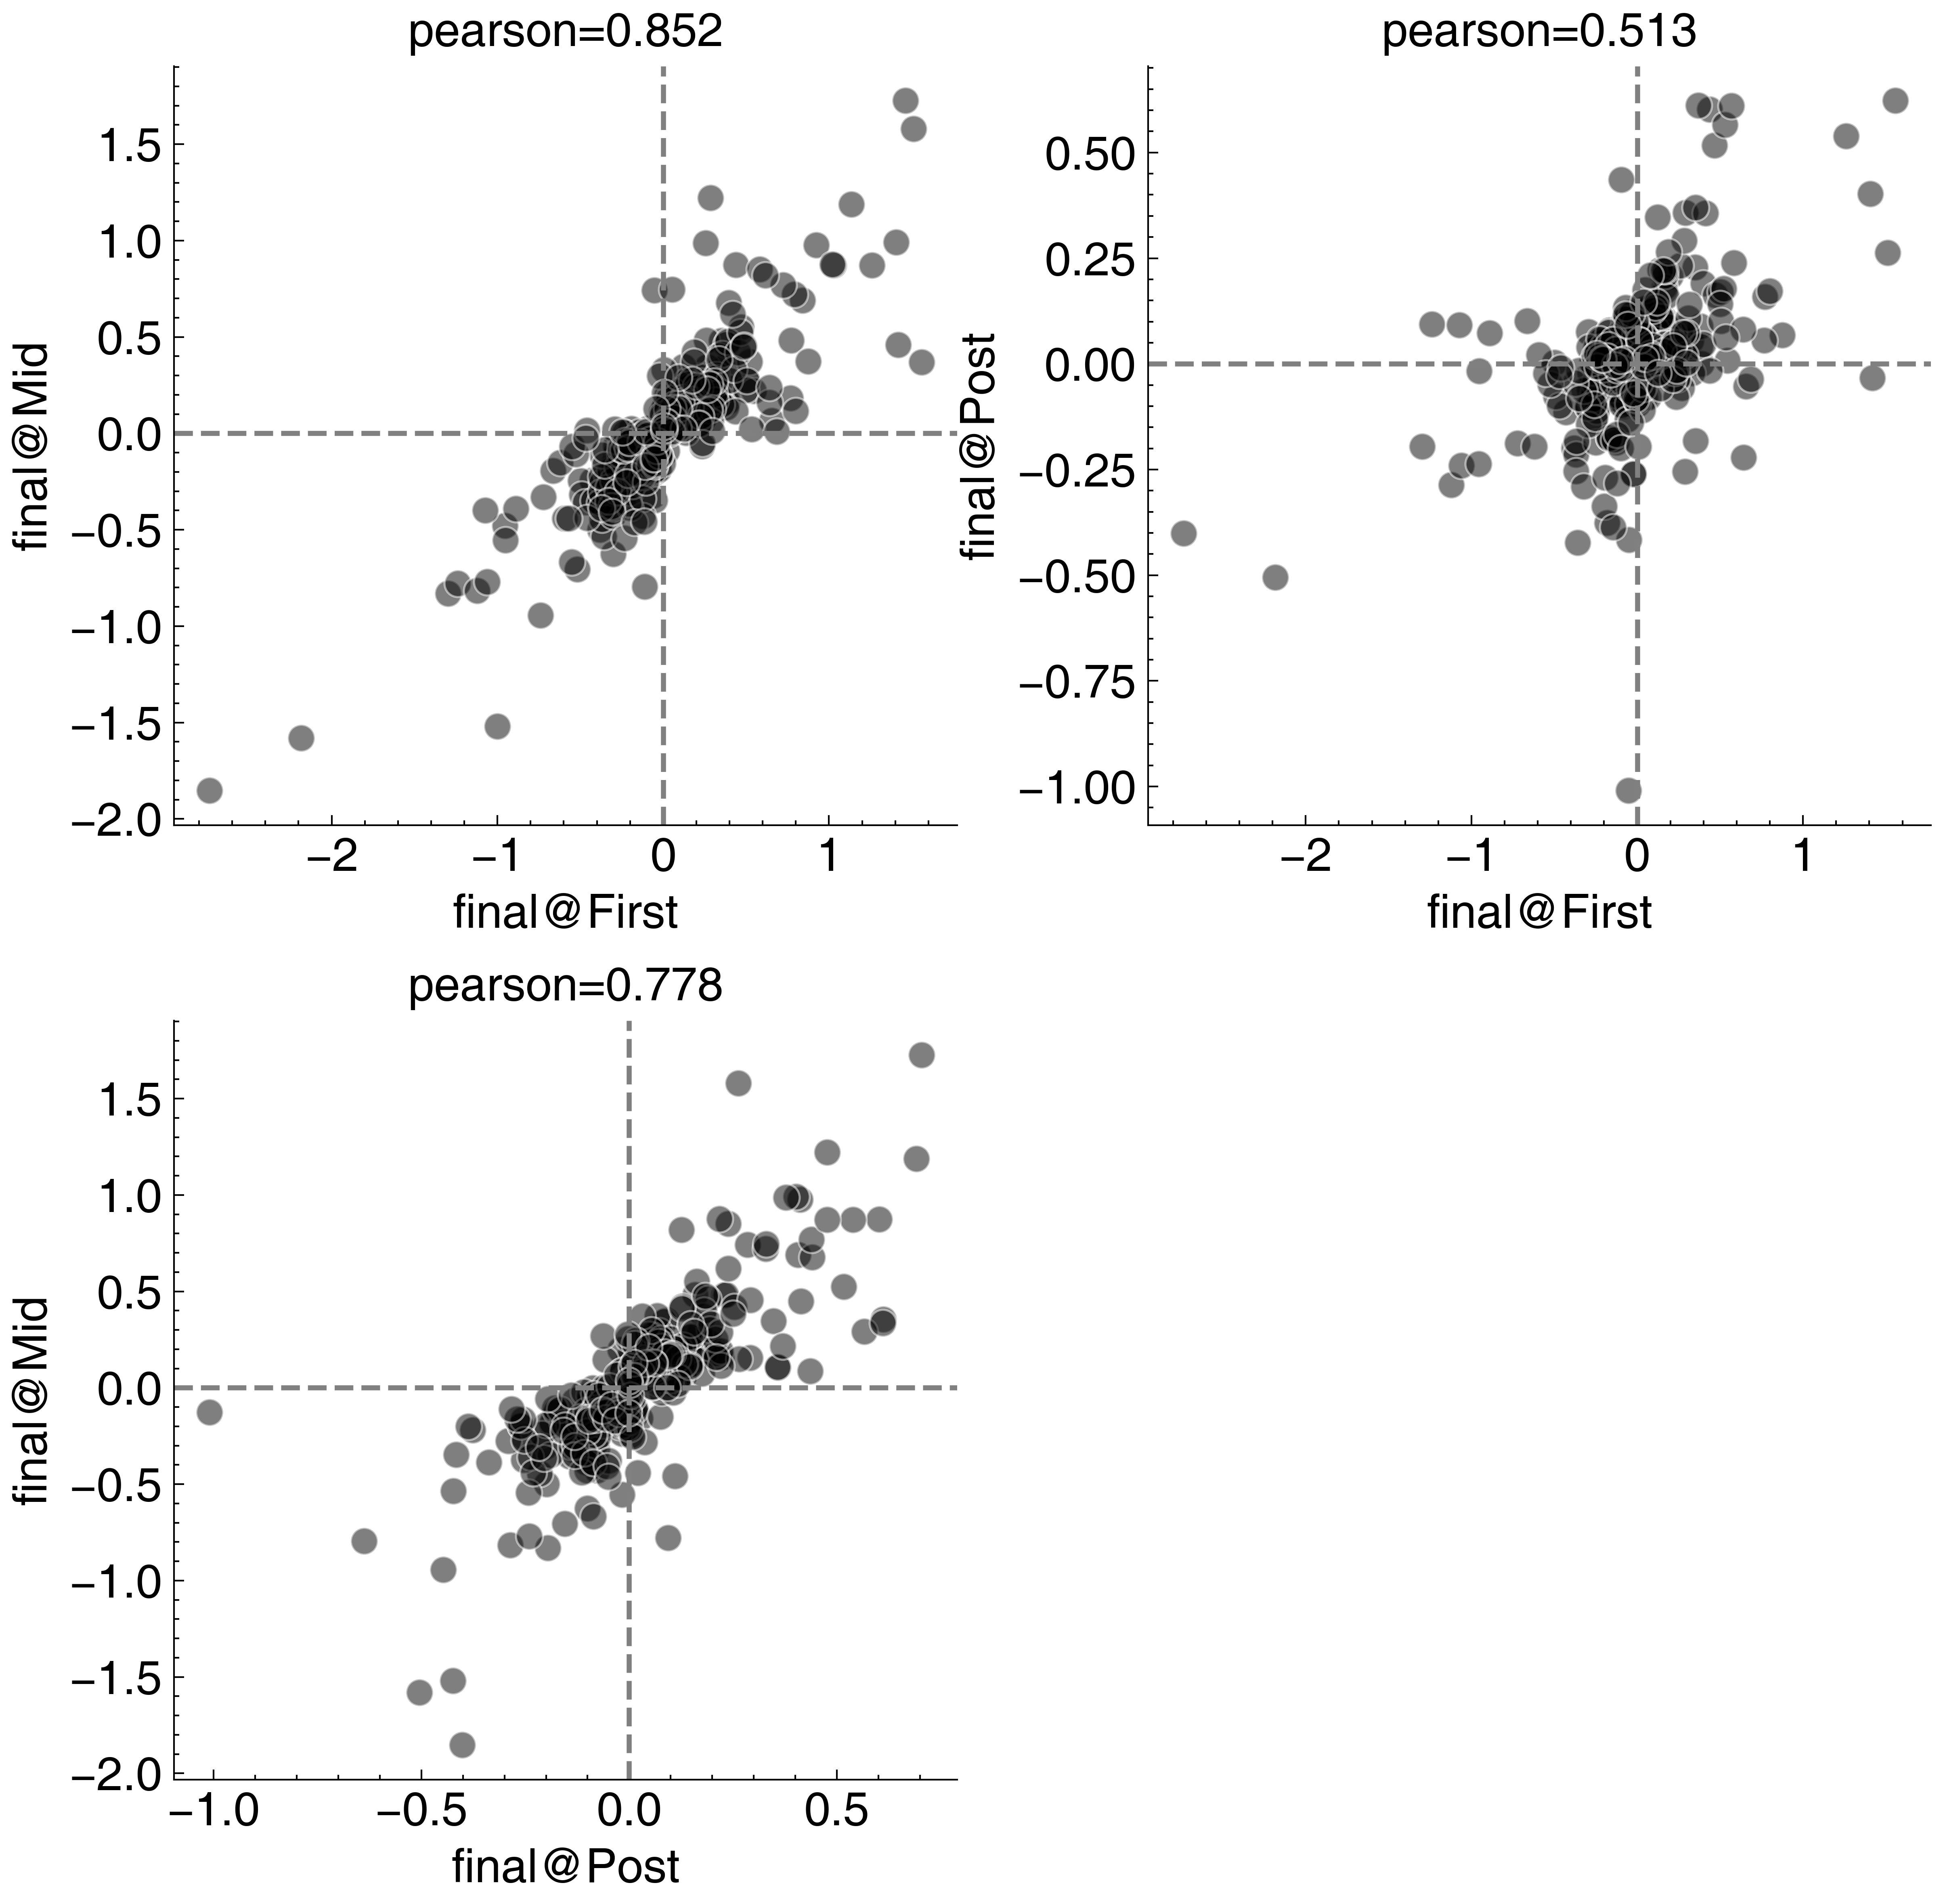

In [16]:
import scipy.stats as ss

xs = ['final@First', 'final@Post']
ys = ['final@Mid', 'final@Post']

comparisons = [(0,0), (0,1), (1,0)]

fig, axs = plt.subplots(2,2, figsize=(8,8))
#fig.suptitle("%s: Time-point comparisons" % EVENT_TYPE)
for i,j in comparisons:
    ax = axs[i,j]
    x = xs[i]
    y = ys[j]
    idx = (jem.stats_sheet[x]['qvals'] < FDR_THRESH ) | (jem.stats_sheet[y]['qvals'] < FDR_THRESH )
    #idx = [x for x in jem.stats_sheet[x].index]
    sns.scatterplot(x=jem.stats_sheet[x].loc[idx, 'coefs'], y=jem.stats_sheet[y].loc[idx, 'coefs'], alpha=0.5, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    #ax.set_title("spearman=%.3f"%ss.spearmanr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs']).correlation)
    ax.set_title("pearson=%.3f"%ss.pearsonr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs'])[0])
    ax.axvline(0, linestyle='--', color="grey")
    ax.axhline(0, linestyle='--', color="grey")
axs[1,1].axis('off')
fig.tight_layout()
fig.savefig("%s/05-timecourse_corr.pdf" % FIGDIR)

In [17]:
jem.stats_sheet.keys()

dict_keys(['intercept', 'final@Asymptomatic', 'final@Exposed', 'final@False Negative', 'final@First', 'final@Immune', 'final@Mid', 'final@Mild', 'final@Moderate', 'final@Post', 'final@Pre', 'final@Reinfection', 'pid', 'Sex@M', 'PC0', 'PC6', '_junc_diff_', 'final4cond'])

In [18]:
finals = {x:covs.factor_conversion['final'][x] for x in ['Pre', 'First', 'Mid', 'Post', 'False Negative', 'Immune']}
coef_cor_mat = np.zeros((len(finals), len(finals)))

obs = [x for x in finals]
for i in range(len(finals)):
    x = finals[obs[i]]
    for j in range(i, len(finals)):
        y = finals[obs[j]]
        idx = (jem.stats_sheet[x]['qvals'] < FDR_THRESH ) | (jem.stats_sheet[y]['qvals'] < FDR_THRESH)
        #idx = [a for a in jem.stats_sheet[x].index] 
        #this_cor = ss.spearmanr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs']).correlation
        try:
            this_cor = ss.pearsonr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs'])[0]
        except ValueError:
            this_cor = 0
        coef_cor_mat[i,j] = this_cor
        coef_cor_mat[j,i] = this_cor
coef_cor_df = pd.DataFrame(coef_cor_mat, columns=obs, index=obs)
coef_cor_df

Pre     First       Mid      Post  False Negative  \
Pre             1.000000  0.328089  0.534885  0.765310        0.265390   
First           0.328089  1.000000  0.852157  0.512544        0.508133   
Mid             0.534885  0.852157  1.000000  0.778483        0.686981   
Post            0.765310  0.512544  0.778483  1.000000        0.272466   
False Negative  0.265390  0.508133  0.686981  0.272466        1.000000   
Immune          0.356508  0.263494  0.468406  0.303843        0.297568   

                  Immune  
Pre             0.356508  
First           0.263494  
Mid             0.468406  
Post            0.303843  
False Negative  0.297568  
Immune          1.000000

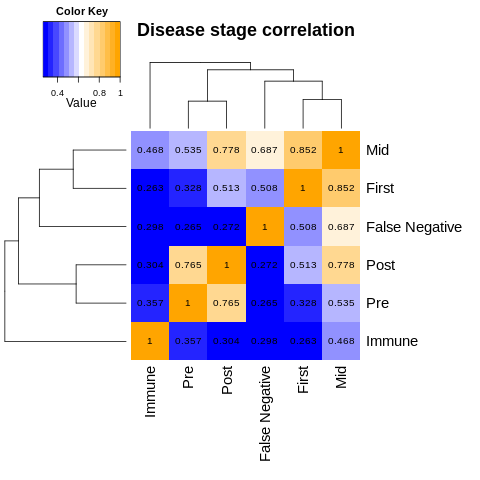

In [19]:
%%R -i coef_cor_df -i FIGDIR
source("R/heatmap.3.R")
y = coef_cor_df
#hr <- hclust(as.dist(1-cor(t(y), method="pearson", use="complete")), method="average")
#hc <- hclust(as.dist(1-cor(y, method="pearson", use="complete")), method="average")
hr <- hclust(dist(y, method="euclidean"), method="average")
hc <- hclust(dist(t(y), method="euclidean"), method="average")

palette <- colorRampPalette(c("blue","white","orange"))

pdf(file.path(FIGDIR, '06-disease_stage_corr.pdf'))
heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "both", col = palette,
  key = TRUE,
  cellnote = round(coef_cor_df, 3),
  notecol = "black",
  main="Disease stage correlation",
  margins=c(10,10)
)
dev.off()
heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "both", col = palette,
  key = TRUE,
  cellnote = round(coef_cor_df, 3),
  notecol = "black",
  main="Disease stage correlation",
  margins=c(10,10)
)

In [20]:
from jemm.utils import logit

def get_N_color(number_of_colors, seed=None):
    np.random.seed(seed)
    color = ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
                 for i in range(number_of_colors)]
    #print(color)
    return color

contrast_col = 'final@First'
target_eids = jem.get_stringent_candidates(contrast_col=contrast_col, qval_thresh=FDR_THRESH, min_change=0.)

psi_jct = jem.junction_measure.reindex(target_eids).applymap(lambda x: logit(x.psi) if pd.notna(x) else None)
psi_txr = jem.transcript_measure.reindex(target_eids).applymap(lambda x: logit(x.psi) if pd.notna(x) else None)

clab = jem.covariates.get_design_mat(['final'])
clab.rename(columns={x:x.split('@')[1] for x in clab.columns}, inplace=True)
rowsum = clab.apply(np.sum, 1)
clab['Control'] = 0
clab.loc[rowsum==0, 'Control'] = 1
# only focus on a few annotations
samp_index = np.where( (clab['Control']==1) | (clab[contrast_col.split('@')[1]]==1) )[0]
#samp_index = np.arange(clab.shape[0])

clab = clab.replace({1:'navyblue', 0:'white'})
clab = clab[['Control', contrast_col.split('@')[1]]]
clab['Plate'] = [covs.meta.loc[i, 'plateNum'] for i in clab.index]

uniq_vals = clab['Plate'].unique()
palette = get_N_color(len(uniq_vals), seed=777)
mapper = {uniq_vals[i]:palette[i] for i in range(len(uniq_vals))}
clab['Plate'] = clab['Plate'].apply(lambda x: mapper[x]) 

jct_plot = psi_jct.iloc[:, samp_index]
txr_plot = psi_txr.iloc[:, samp_index]
clab_plot = clab.iloc[samp_index]
txr_plot.head(3)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

20_0149-T00  20_0150-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.859104     2.870986   
chr22:-:50529731:50529903:50529719:50529903       -1.874224    -1.780526   
chr7:-:129839335:129857510:129839275:129857510     0.481680     0.337510   

                                                20_0151-T00  20_0152-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.944439     2.944439   
chr22:-:50529731:50529903:50529719:50529903       -1.492592    -1.895627   
chr7:-:129839335:129857510:129839275:129857510    -0.237967     0.779476   

                                                20_0152-T28  20_0152-T53  \
chr22:+:32475398:32478980:32475398:32479132        2.944439     2.944439   
chr22:-:50529731:50529903:50529719:50529903       -1.774172    -1.947529   
chr7:-:129839335:129857510:129839275:129857510     2.458712     2.810058   

                                                20_0153-T00  20_0154-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.944439     2.616413   
chr22:-:50529731:50529903:50529719:50529903       -1.608443    -1.851610   
chr7:-:129839335:129857510:129839275:129857510    -0.685060    -0.297646   

                                                20_0155-T00  20_0156-T00  ...  \
chr22:+:32475398:32478980:32475398:32479132        2.944439     2.749416  ...   
chr22:-:50529731:50529903:50529719:50529903       -1.995086    -1.749682  ...   
chr7:-:129839335:129857510:129839275:129857510    -0.885172     0.254117  ...   

                                                20_2303-T00  20_2305-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.944439     2.878554   
chr22:-:50529731:50529903:50529719:50529903       -1.495453    -1.653355   
chr7:-:129839335:129857510:129839275:129857510     2.944439     1.777857   

                                                20_2311-T00  20_2341-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.634748     2.944439   
chr22:-:50529731:50529903:50529719:50529903       -1.878151    -1.439098   
chr7:-:129839335:129857510:129839275:129857510     1.068932     1.024257   

                                                20_2425-T00  20_2430-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.944439     2.944439   
chr22:-:50529731:50529903:50529719:50529903       -1.012938    -1.677081   
chr7:-:129839335:129857510:129839275:129857510     2.944439     0.004249   

                                                20_2430-T35  20_2461-T00  \
chr22:+:32475398:32478980:32475398:32479132        2.524979     2.944439   
chr22:-:50529731:50529903:50529719:50529903       -1.980081    -1.422061   
chr7:-:129839335:129857510:129839275:129857510     0.910584     0.526976   

                                                20_2485-T00  20_2512-T00  
chr22:+:32475398:32478980:32475398:32479132        2.416020     2.944439  
chr22:-:50529731:50529903:50529719:50529903       -1.457861    -1.668319  
chr7:-:129839335:129857510:129839275:129857510     0.325705     0.840297  

[3 rows x 278 columns]

[1] 128 278
filled_na= 546 
[1] 128
[1] 128 278
[1] 128 278
filled_na= 546 
[1] 128
[1] 128 278


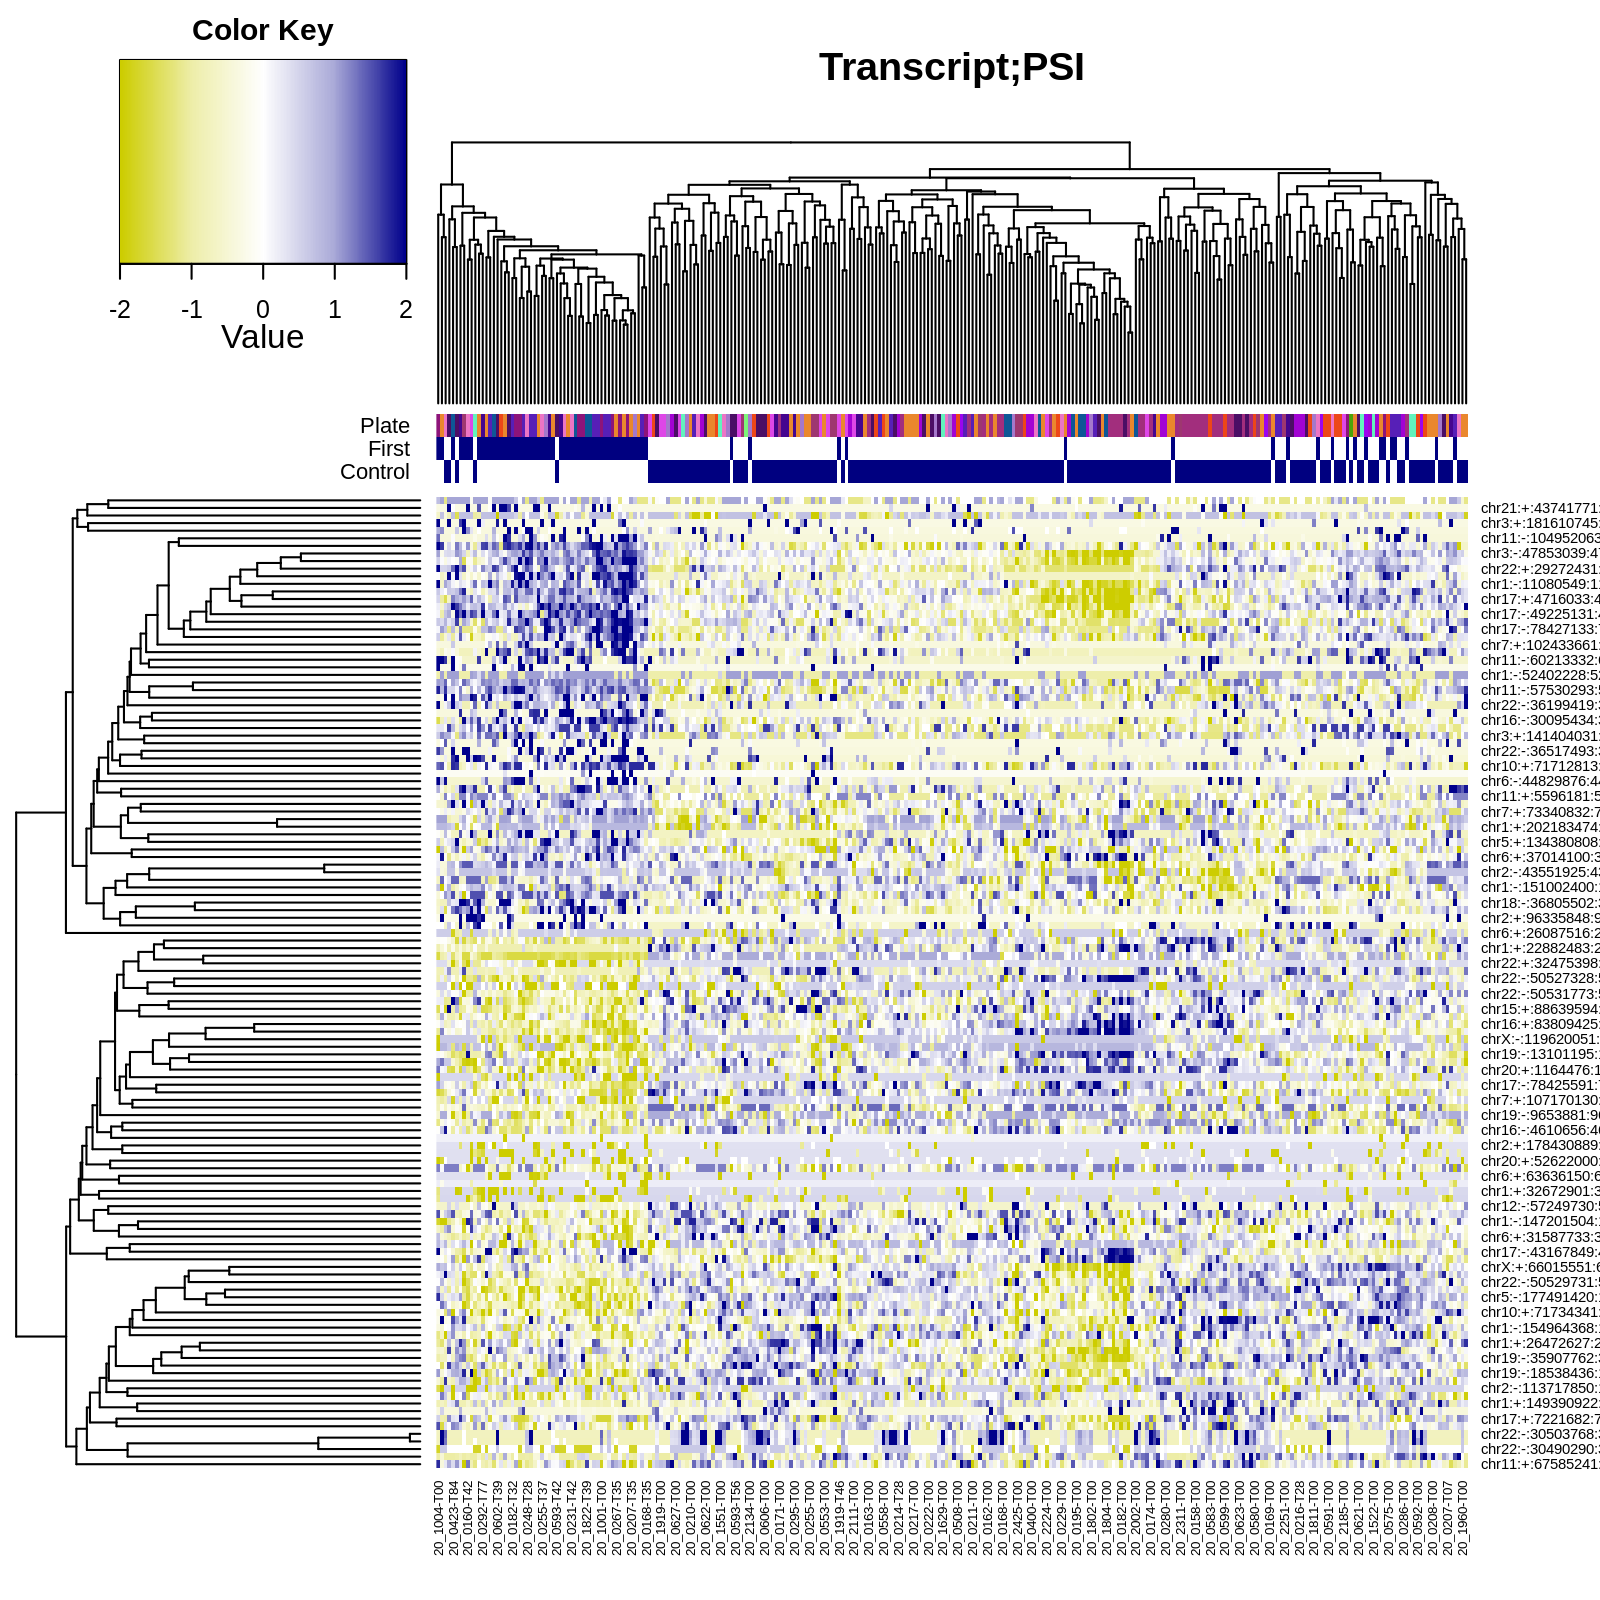

In [21]:
%%R -i txr_plot -i clab_plot -w 8 -h 8 --units in -r 200
source('notebook/navy_utils.R')
pdf(file.path(FIGDIR, "07-First_Txr_cluster.pdf"), width=5, height=8)
g = plot_heatmap(txr_plot, clab_plot, main="Transcript;PSI", do_scale=T)
dev.off()
g = plot_heatmap(txr_plot, clab_plot, main="Transcript;PSI", do_scale=T)

## 3. Get the high-confidence events

Definition of "high-confidence":
- "significant" as qval<0.05

In [22]:
print('Sig count:')
pd.DataFrame(jem.get_das_cnt(target_covariate='final', qval_thresh=FDR_THRESH), index=[EVENT_TYPE])

Sig count:


Asymptomatic  Exposed  False Negative  First  Immune  Mid  Mild  \
A3SS           310       84              12    194      13  309   191   

      Moderate  Post  Pre  Reinfection  
A3SS       148   111   17           34

In [23]:
target_contrasts = [
    'final@Pre',
    'final@First',
    'final@Mid',
    'final@Post',
    #'final@False Negative',
    #'final@Immune'
]
covs.meta['final'].value_counts()

Post              334
Mid               254
Control           206
Asymptomatic       80
First              72
Mild               54
Pre                48
Moderate           43
Exposed            38
Immune             25
False Negative     17
Reinfection         5
Name: final, dtype: int64

In [24]:
event_catelog = defaultdict(dict)

for eid in jem.stats_tests:
    target_ = jem.stats_tests[eid].loc[target_contrasts]
    target_ = target_.loc[target_['qvals']<FDR_THRESH]['coef'].to_dict()
    if len(target_):
        event_catelog[eid] = target_


In [25]:
up_catelog = {}
dn_catelog = {}
for eid in event_catelog:
    ups = [x for x in event_catelog[eid] if event_catelog[eid][x]>0]
    dns = [x for x in event_catelog[eid] if event_catelog[eid][x]<0]
    if len(ups) >= 1:
        up_catelog[eid] = ups
    if len(dns) >= 1:
        dn_catelog[eid] = dns


print("Upregulated n=%i"%len(up_catelog))
print("Downregulated n=%i"%len(dn_catelog))

Upregulated n=254
Downregulated n=229


In [26]:
# store all sig. events
das_up_eids = [e for e in up_catelog]
das_dn_eids = [e for e in dn_catelog]
das_eids = list(set(das_up_eids + das_dn_eids))

In [27]:
# "high-contrast" events should be very few
high_contrasts = [e for e in up_catelog if e in dn_catelog]
print("High-contrast n=%i"%len(high_contrasts))

High-contrast n=1


## 4. Annotate the DAS events and genes

(254, 2)


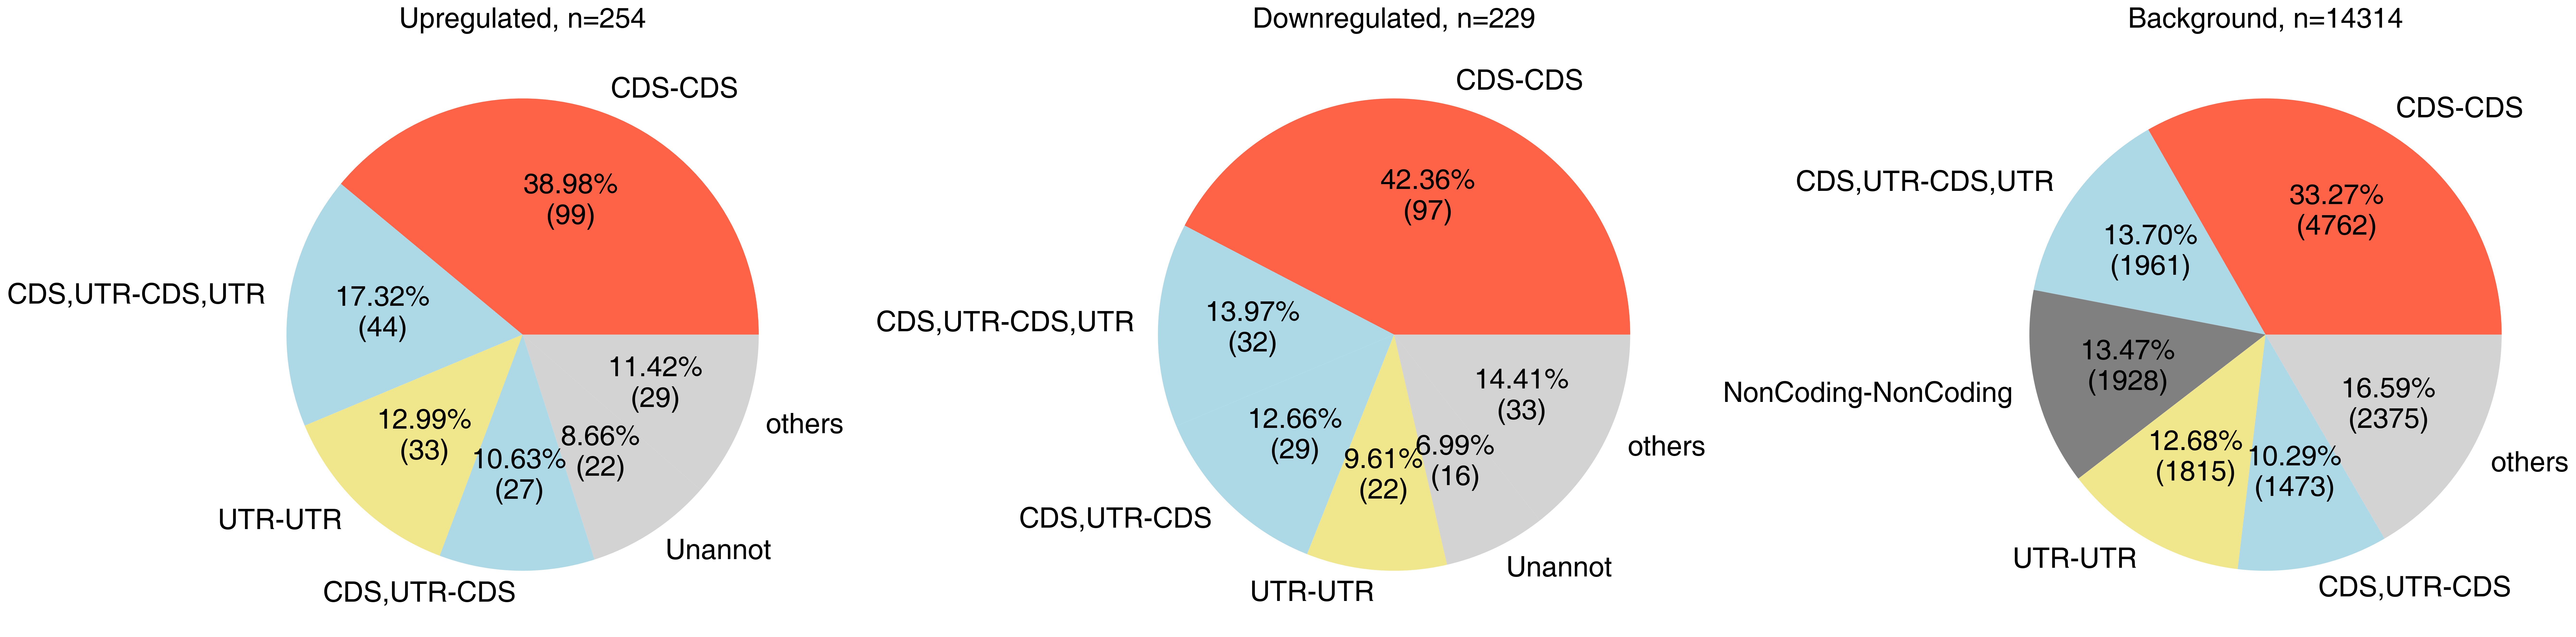

In [28]:
if USE_ANNOT:
    # Get annotation
    das_up_exons = exonset.get_splice_site_annotations(eids=das_up_eids, annotations=['coding_region', 'pfam_domain'])
    das_dn_exons = exonset.get_splice_site_annotations(eids=das_dn_eids, annotations=['coding_region', 'pfam_domain'])
    bg = exonset.get_splice_site_annotations(eids=[e for e in jem.stats_tests], annotations=['coding_region'])

    print(das_up_exons.shape)

    # Replace undef
    unannot = [
        x for x in bg['coding_region'].unique() 
        if 'NonCoding' in x
        and x != 'NonCoding-NonCoding']
    das_up_exons['coding_region'].replace(to_replace=unannot, value='Unannot', inplace=True)
    das_dn_exons['coding_region'].replace(to_replace=unannot, value='Unannot', inplace=True)

    # Plot
    def color_maker(k):
        c = 'lightgrey'
        if 'CDS' in k:
            c = 'tomato'
        if 'UTR' in k:
            c = 'khaki'
        if 'CDS' in k and 'UTR' in k:
            c = 'lightblue'
        if k == 'NonCoding-NonCoding':
            c = 'grey'
        return c

    color_map = {k: color_maker(k) for k in bg['coding_region'].unique()}


    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
        return my_autopct


    fig, axs = plt.subplots(1, 3, figsize=(18,54))

    up_das_cnt = das_up_exons['coding_region'].value_counts()
    others = up_das_cnt.iloc[5:].sum()
    up_das_cnt = up_das_cnt.head(5)
    up_das_cnt['others'] = others
    up_das_color = [color_map[x] if x in color_map else 'lightgrey' for x in up_das_cnt.index]
    up_das_cnt.plot.pie(colors=up_das_color, autopct=make_autopct(up_das_cnt), fontsize=14, label="Upregulated", ax=axs[0])
    axs[0].set_title('Upregulated, n=%i'%up_das_cnt.sum())
    axs[0].set_ylabel('')

    dn_das_cnt = das_dn_exons['coding_region'].value_counts()
    others = dn_das_cnt.iloc[5:].sum()
    dn_das_cnt = dn_das_cnt.head(5)
    dn_das_cnt['others'] = others
    dn_das_color = [color_map[x] if x in color_map else 'lightgrey' for x in dn_das_cnt.index]
    dn_das_cnt.plot.pie(colors=dn_das_color, autopct=make_autopct(dn_das_cnt), fontsize=14, label="Upregulated", ax=axs[1])
    axs[1].set_title('Downregulated, n=%i'%dn_das_cnt.sum())
    axs[1].set_ylabel('')

    bg['coding_region'].replace(to_replace=unannot, value='Unannot', inplace=True)
    bg_cnt = bg['coding_region'].value_counts()
    bg_cnt = bg['coding_region'].value_counts()    
    others = bg_cnt.iloc[5:].sum()
    bg_cnt = bg_cnt.head(5)
    bg_cnt['others'] = others
    bg_color = [color_map[x] if x in color_map else 'lightgrey' for x in bg_cnt.index]
    bg_cnt.plot.pie(colors=bg_color, autopct=make_autopct(bg_cnt), fontsize=14, label="All tested", ax=axs[2])
    axs[2].set_title('Background, n=%i'%bg_cnt.sum())
    axs[2].set_ylabel('')
    
    fig.tight_layout()
    fig.savefig("%s/08-CDS_piecharts.pdf" % FIGDIR)
    plt.show()
else:
    print('Skipped Annot')

## 4.1 Splice site annotations
Now make the plots for exon annotations

In [29]:
das_annot = exonset.get_splice_site_annotations(eids=das_eids, annotations=['rbp_clip', 'pfam_domain'])
bg_annot = exonset.get_splice_site_annotations(eids=[e for e in jem.stats_tests], annotations=['rbp_clip','pfam_domain'])

In [30]:
from collections import Counter
from jemm.utils import fdr_bh
das_cnts = Counter([clip for eid_clip in das_annot['rbp_clip'] for clip in eid_clip.split('|')])
bg_cnts = Counter([clip for eid_clip in bg_annot['rbp_clip'] for clip in eid_clip.split('|')])

In [31]:
das_tot_cnt = das_annot.shape[0]
bg_tot_cnt = bg_annot.shape[0]
peaks = []
ratios = []
pvals = []
for peak in bg_cnts:
    if not len(peak): continue
    das_obs_cnt = das_cnts[peak]
    bg_obs_cnt = bg_cnts[peak]
    mat = np.array([[das_obs_cnt, bg_obs_cnt], [das_tot_cnt, bg_tot_cnt]])
    res = scipy.stats.fisher_exact(mat)
    peaks.append(peak)
    ratios.append(res[0])
    pvals.append(res[1])

clip_test = pd.DataFrame({'peaks': peaks, 'ratios': ratios, 'pvals': pvals})

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


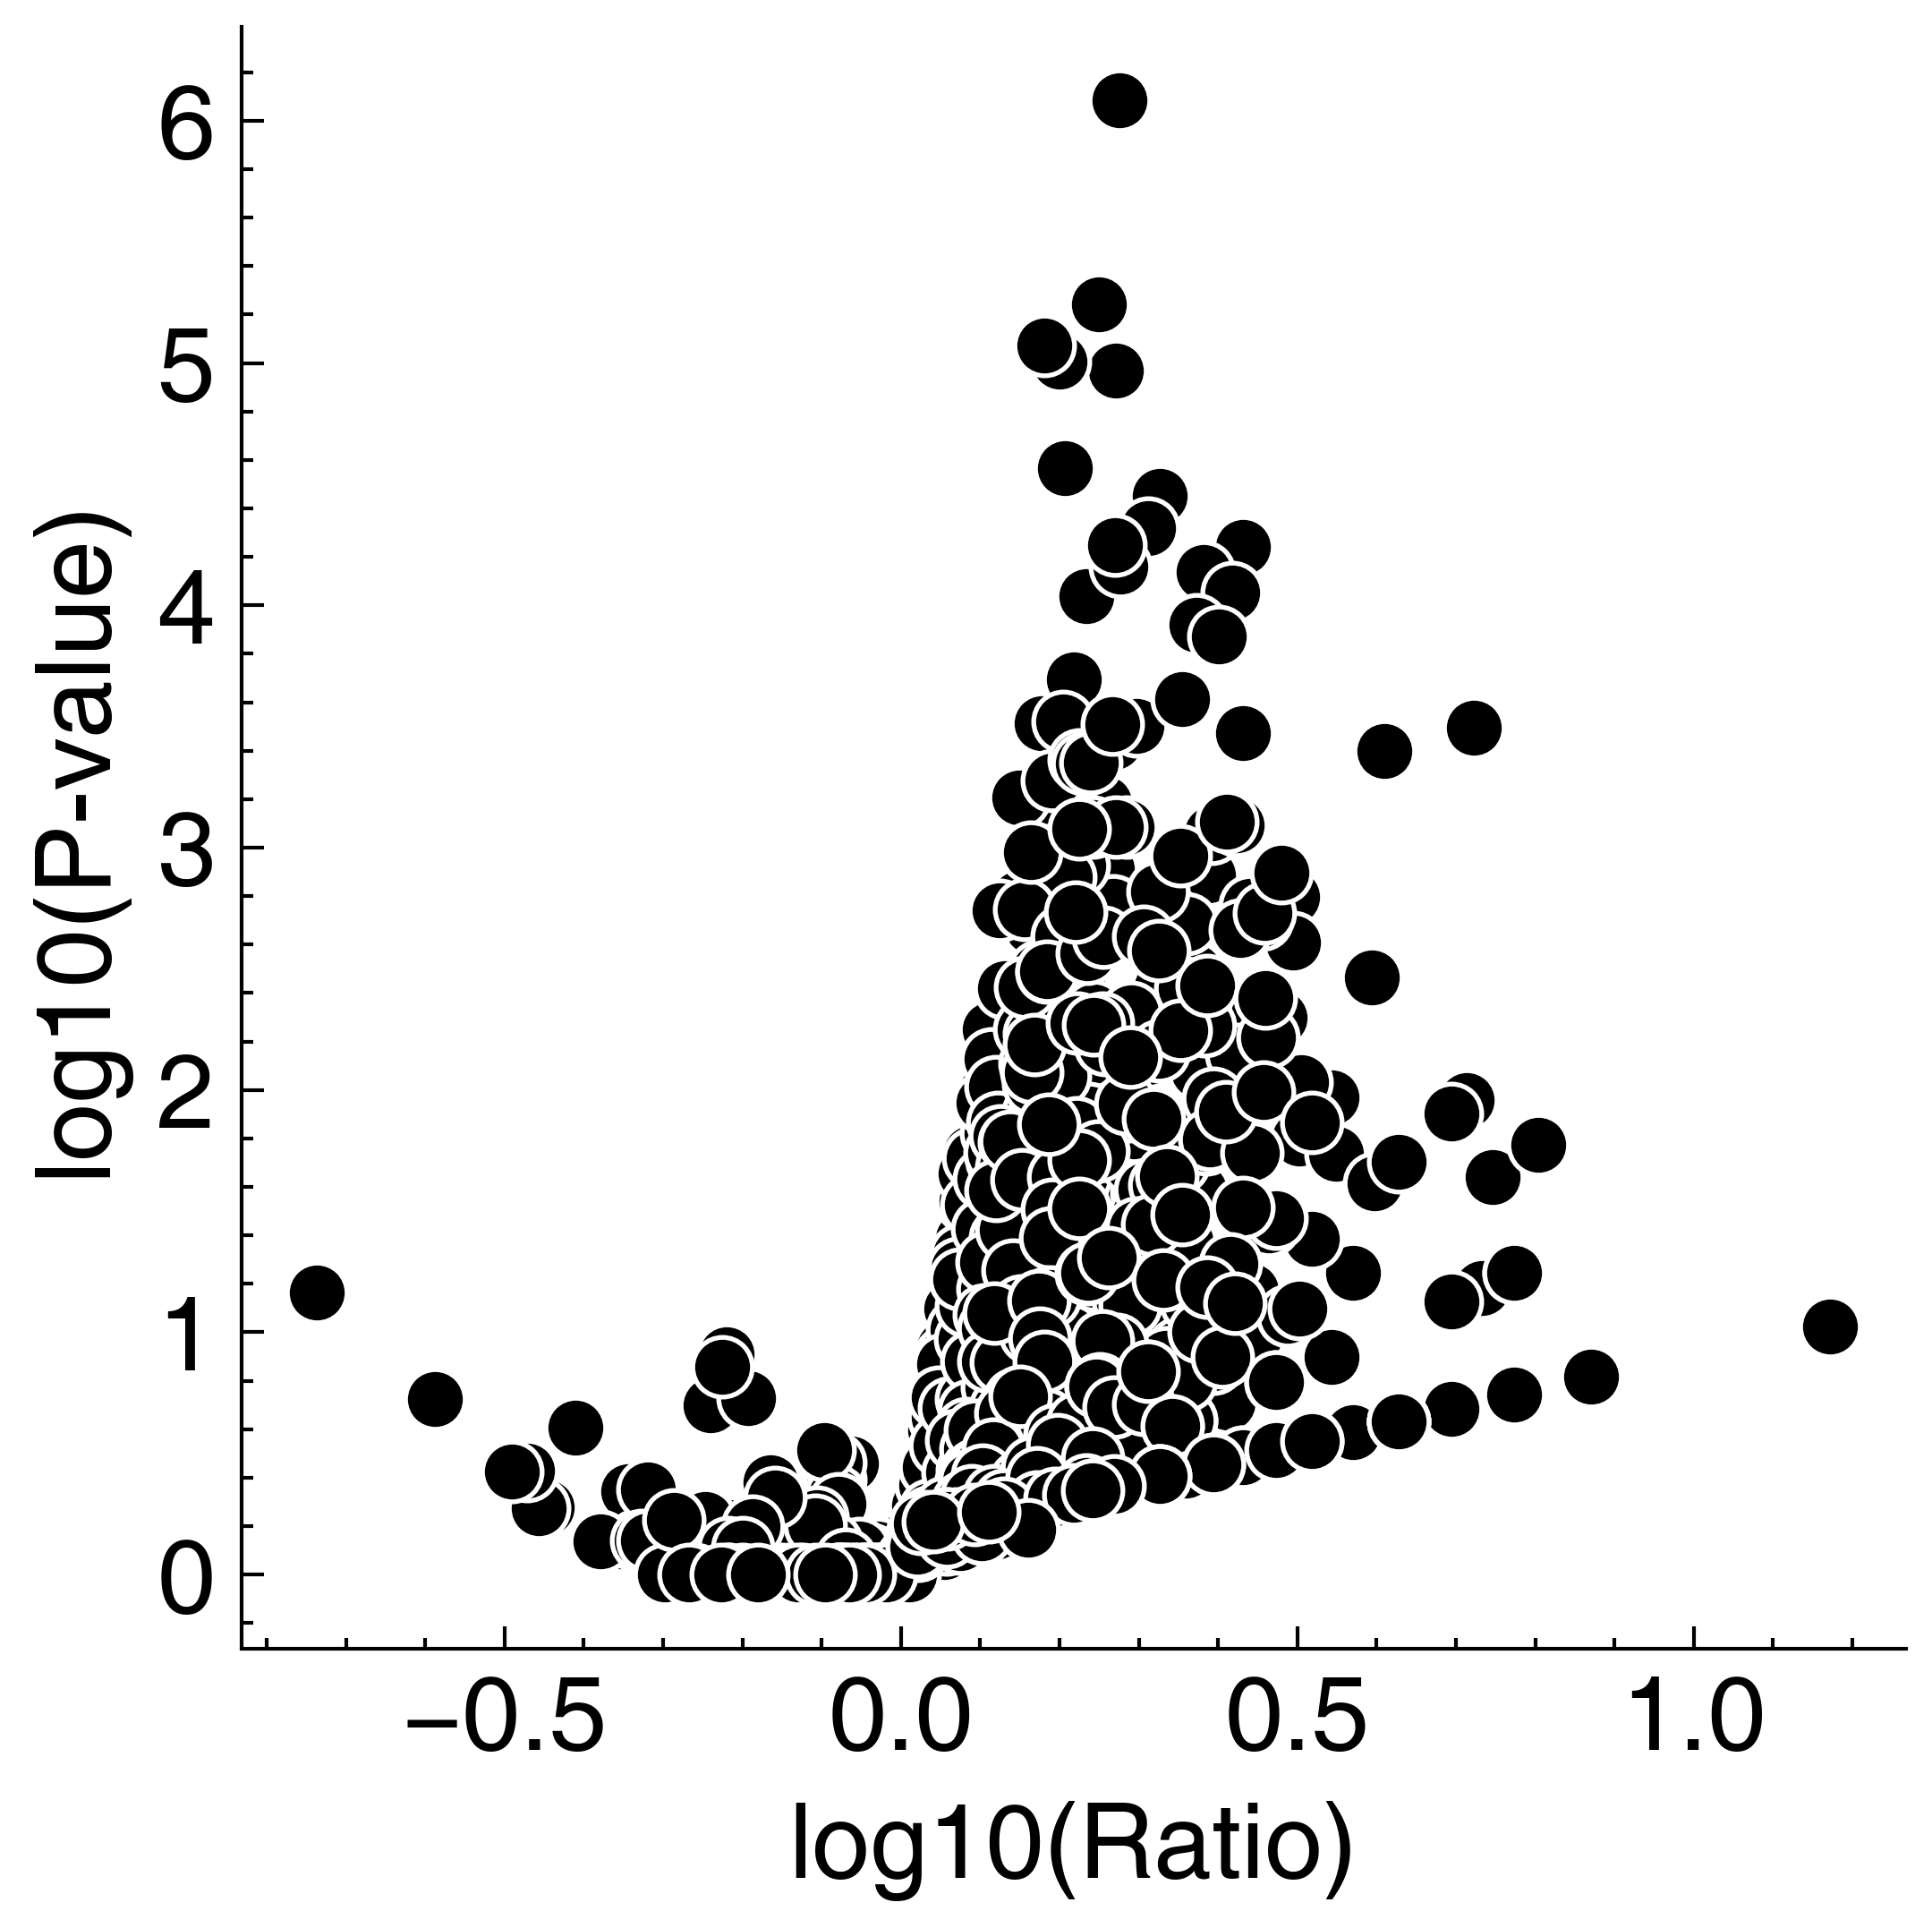

In [32]:
# vocalno plot
ax = sns.scatterplot(x=np.log10(clip_test['ratios']), y=-np.log10(clip_test['pvals']))
ax.set_xlabel('log10(Ratio)')
ax.set_ylabel('log10(P-value)')
plt.savefig("%s/09-clip_test_volcano.pdf"%FIGDIR)

In [33]:
clip_test['fdr'] = fdr_bh(clip_test['pvals'])
clip_test.sort_values('pvals', ascending=True).to_csv("%s/clip_test.tsv"%OUTDIR, sep="\t", index=False)
clip_test.query('fdr < 0.01 and ratios>=2').sort_values('fdr', ascending=True)

peaks    ratios     pvals       fdr
91   IGF2BP2_K562_eCLIP-ENCODE  2.117532  0.000035  0.004777
94      XRN2_K562_eCLIP-ENCODE  2.051291  0.000048  0.005434
192            TIAL1_HepG2_IDR  2.699736  0.000058  0.005434
231            PABPC4_K562_IDR  2.405631  0.000073  0.005707
256            METAP2_K562_IDR  2.616985  0.000088  0.006172
287            LARP4_HepG2_IDR  2.355577  0.000120  0.007544
326            ZNF800_K562_IDR  2.518482  0.000135  0.007943

## 4.2 Gene annotations

Now annotate the events to genes:

In [34]:
genes = [g for g in list(set([exonset.loc[e]['geneSymbol'] for e in das_eids])) if g is not None]
print("Total n=%i genes with DAS; below are random 10 genes:"%len(genes))
print("\n".join(genes[0:10]))

Total n=409 genes with DAS; below are random 10 genes:
GORASP1
HFE
SLC25A4
PLEKHG2
BAG6
ARHGEF40
MARS1
PHOSPHO1
MIR22HG
MTSS1


In [35]:
import gseapy
import shutil
if os.path.isdir(os.path.join(OUTDIR, 'GOBP/')):
    shutil.rmtree(os.path.join(OUTDIR, 'GOBP/'))

try:
    gseapy.enrichr(gene_list=list(genes), description='pathway', gene_sets='GO_Biological_Process_2018',
                   outdir=os.path.join(OUTDIR, 'GOBP/'),
                   format="png",
                   cutoff=0.1,
                  )
    enrichr = pd.read_table(os.path.join(OUTDIR, "GOBP/GO_Biological_Process_2018.human.enrichr.reports.txt"))
    enrichr.sort_values(by="Adjusted P-value", ascending=True).head(n=5)
except:
    print('GSEApy failed')

## 5. Analysis of temporal change

In [36]:
pre_eids = jem.get_stringent_candidates(contrast_col='final@Pre', qval_thresh=FDR_THRESH, min_change=0.0,
                                         is_consistent_measure=False)
print(len(pre_eids))

11


In [37]:
import shutil
if os.path.isdir(os.path.join(OUTDIR, 'pre/enrichr_covid_set/')):
    shutil.rmtree(os.path.join(OUTDIR, 'pre/enrichr_covid_set/'))
pre_genes = [g for g in list(set([exonset.loc[e]['geneSymbol'] for e in pre_eids])) if g is not None]
try:
    gseapy.enrichr(gene_list=list(pre_genes), description='pathway', gene_sets='COVID-19_Related_Gene_Sets',
                   outdir=os.path.join(OUTDIR, 'pre/enrichr_covid_set/'),
                   format="png",
                   cutoff=0.1,
                  )
except:
    print('GSEApy failed')

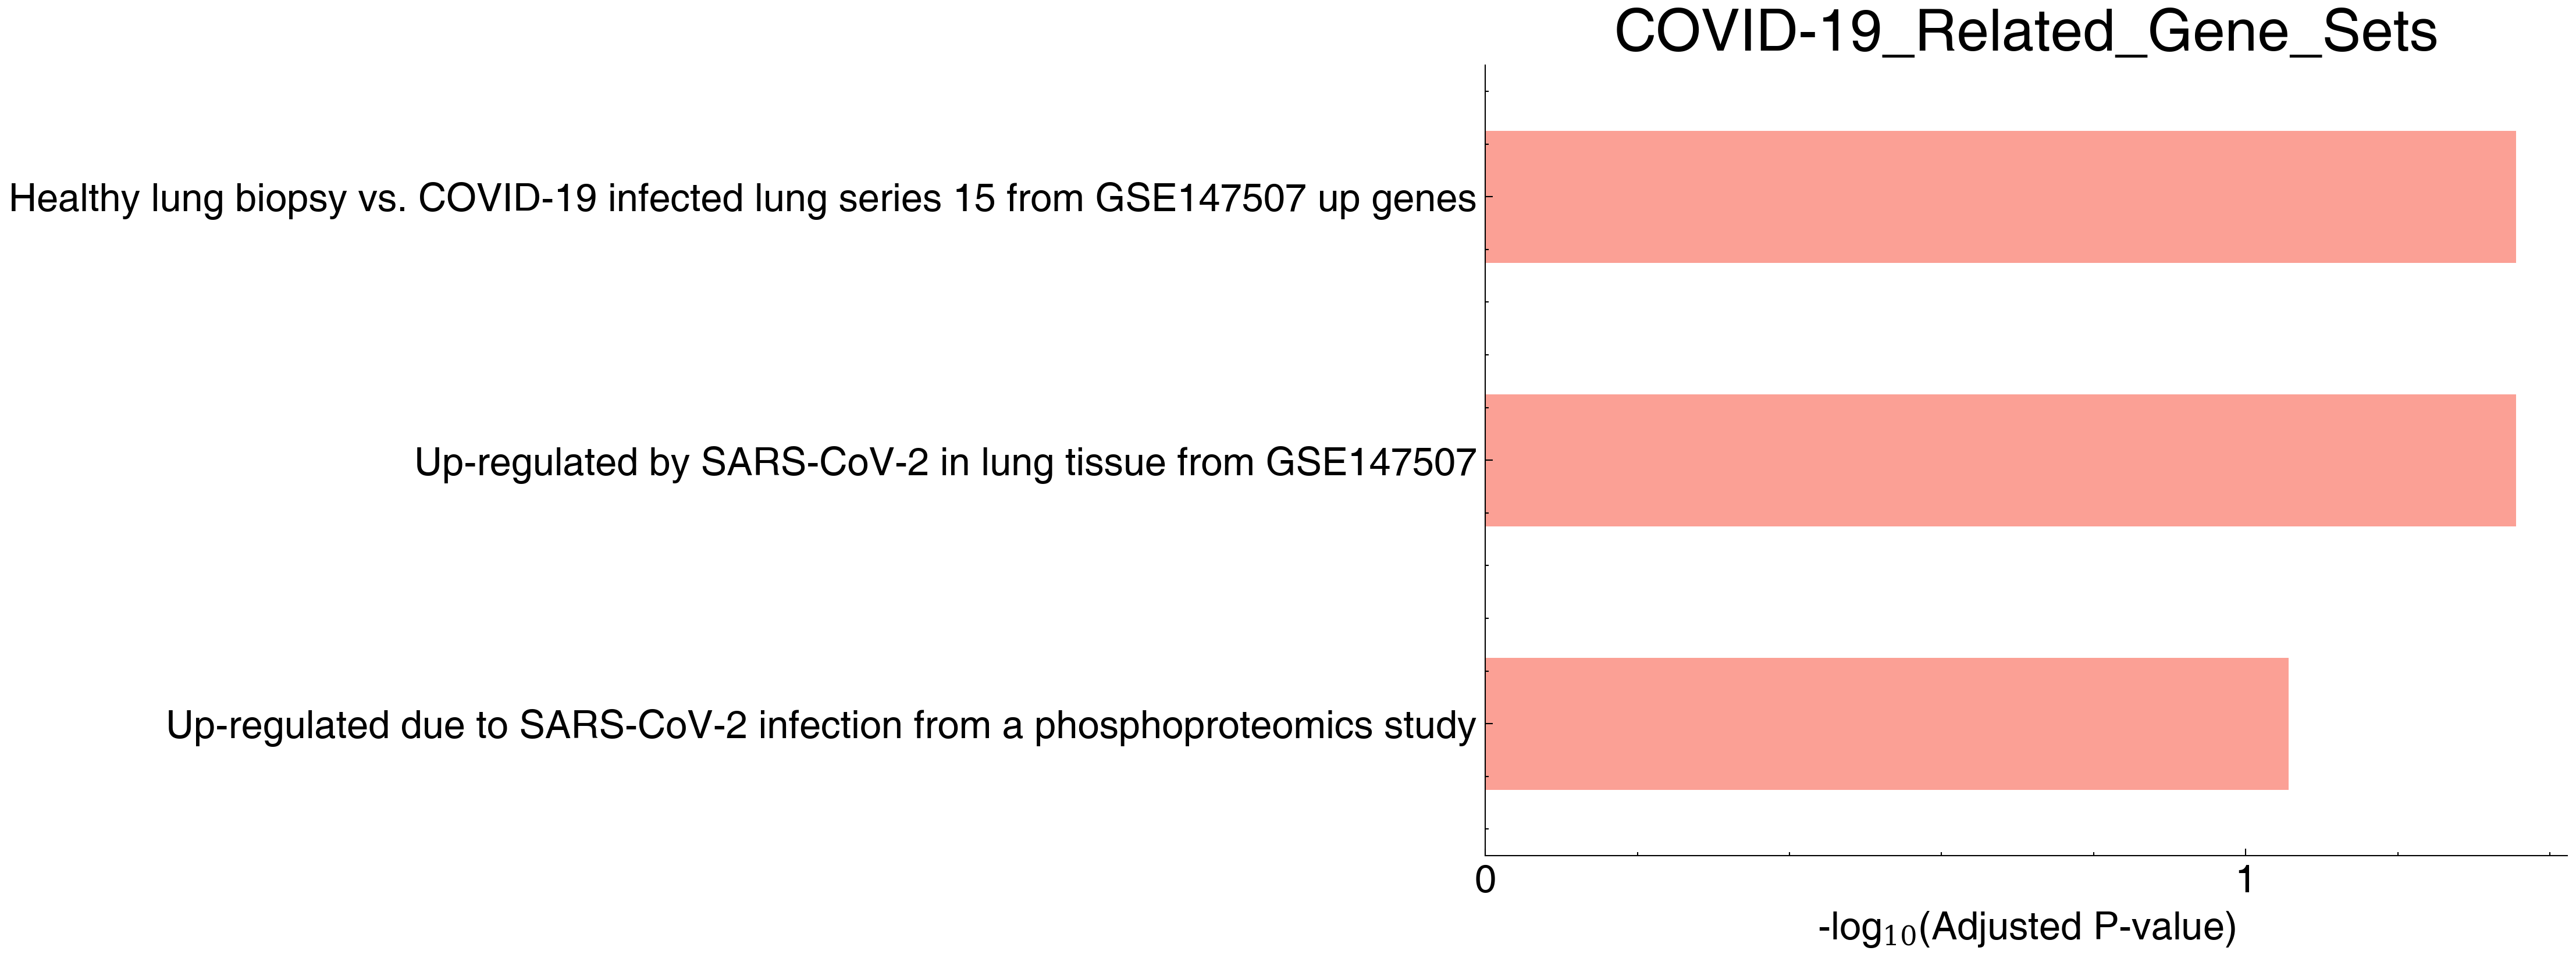

In [38]:
enrichr_fig = os.path.join(OUTDIR, 'pre/enrichr_covid_set/COVID-19_Related_Gene_Sets.human.enrichr.reports.png')
try:
    from IPython.display import Image, display
    i=Image(filename=enrichr_fig)
    display(i)
except:
    print("NO ENRICHMENT FOUND")    

In [39]:
if os.path.isdir(os.path.join(OUTDIR, 'pre/GOBP/')):
    shutil.rmtree(os.path.join(OUTDIR, 'pre/GOBP/'))
pre_genes = list(set([exonset.loc[e]['geneSymbol'] for e in pre_eids]))
try:
    gseapy.enrichr(gene_list=list(pre_genes), description='pathway', gene_sets='GO_Biological_Process_2018',
                   outdir=os.path.join(OUTDIR, 'pre/GOBP/'),
                   format="png",
                   cutoff=0.1,
                  )
except:
    print('GSEApy failed')

In [40]:
longitudinal_df = pd.DataFrame({
    'pre': jem.stats_sheet['final@Pre'].loc[pre_eids, 'coefs'],
    'first': jem.stats_sheet['final@First'].loc[pre_eids, 'coefs'],
    'mid': jem.stats_sheet['final@Mid'].loc[pre_eids, 'coefs'],
    'post': jem.stats_sheet['final@Post'].loc[pre_eids, 'coefs'],
})

In [41]:
longitudinal_df.head(3)

pre    first      mid  \
chr14:-:94383379:94388559:94383241:94388559     0.12608 -0.00924  0.11084   
chr1:+:161510074:161510833:161510074:161510840 -0.10985 -0.08150 -0.13663   
chr6:-:109446412:109446695:109446357:109446695 -0.10749  0.04695 -0.03229   

                                                   post  
chr14:-:94383379:94388559:94383241:94388559     0.08386  
chr1:+:161510074:161510833:161510074:161510840 -0.09979  
chr6:-:109446412:109446695:109446357:109446695 -0.07976

In [42]:
up_lt_df = longitudinal_df.loc[longitudinal_df['pre']>0]
dn_lt_df = longitudinal_df.loc[longitudinal_df['pre']<0]
print(up_lt_df.mean(axis=0))
print(dn_lt_df.mean(axis=0))

pre      0.488829
first    0.170493
mid      0.112320
post     0.208643
dtype: float64
pre     -0.136500
first   -0.026723
mid     -0.060085
post    -0.073975
dtype: float64


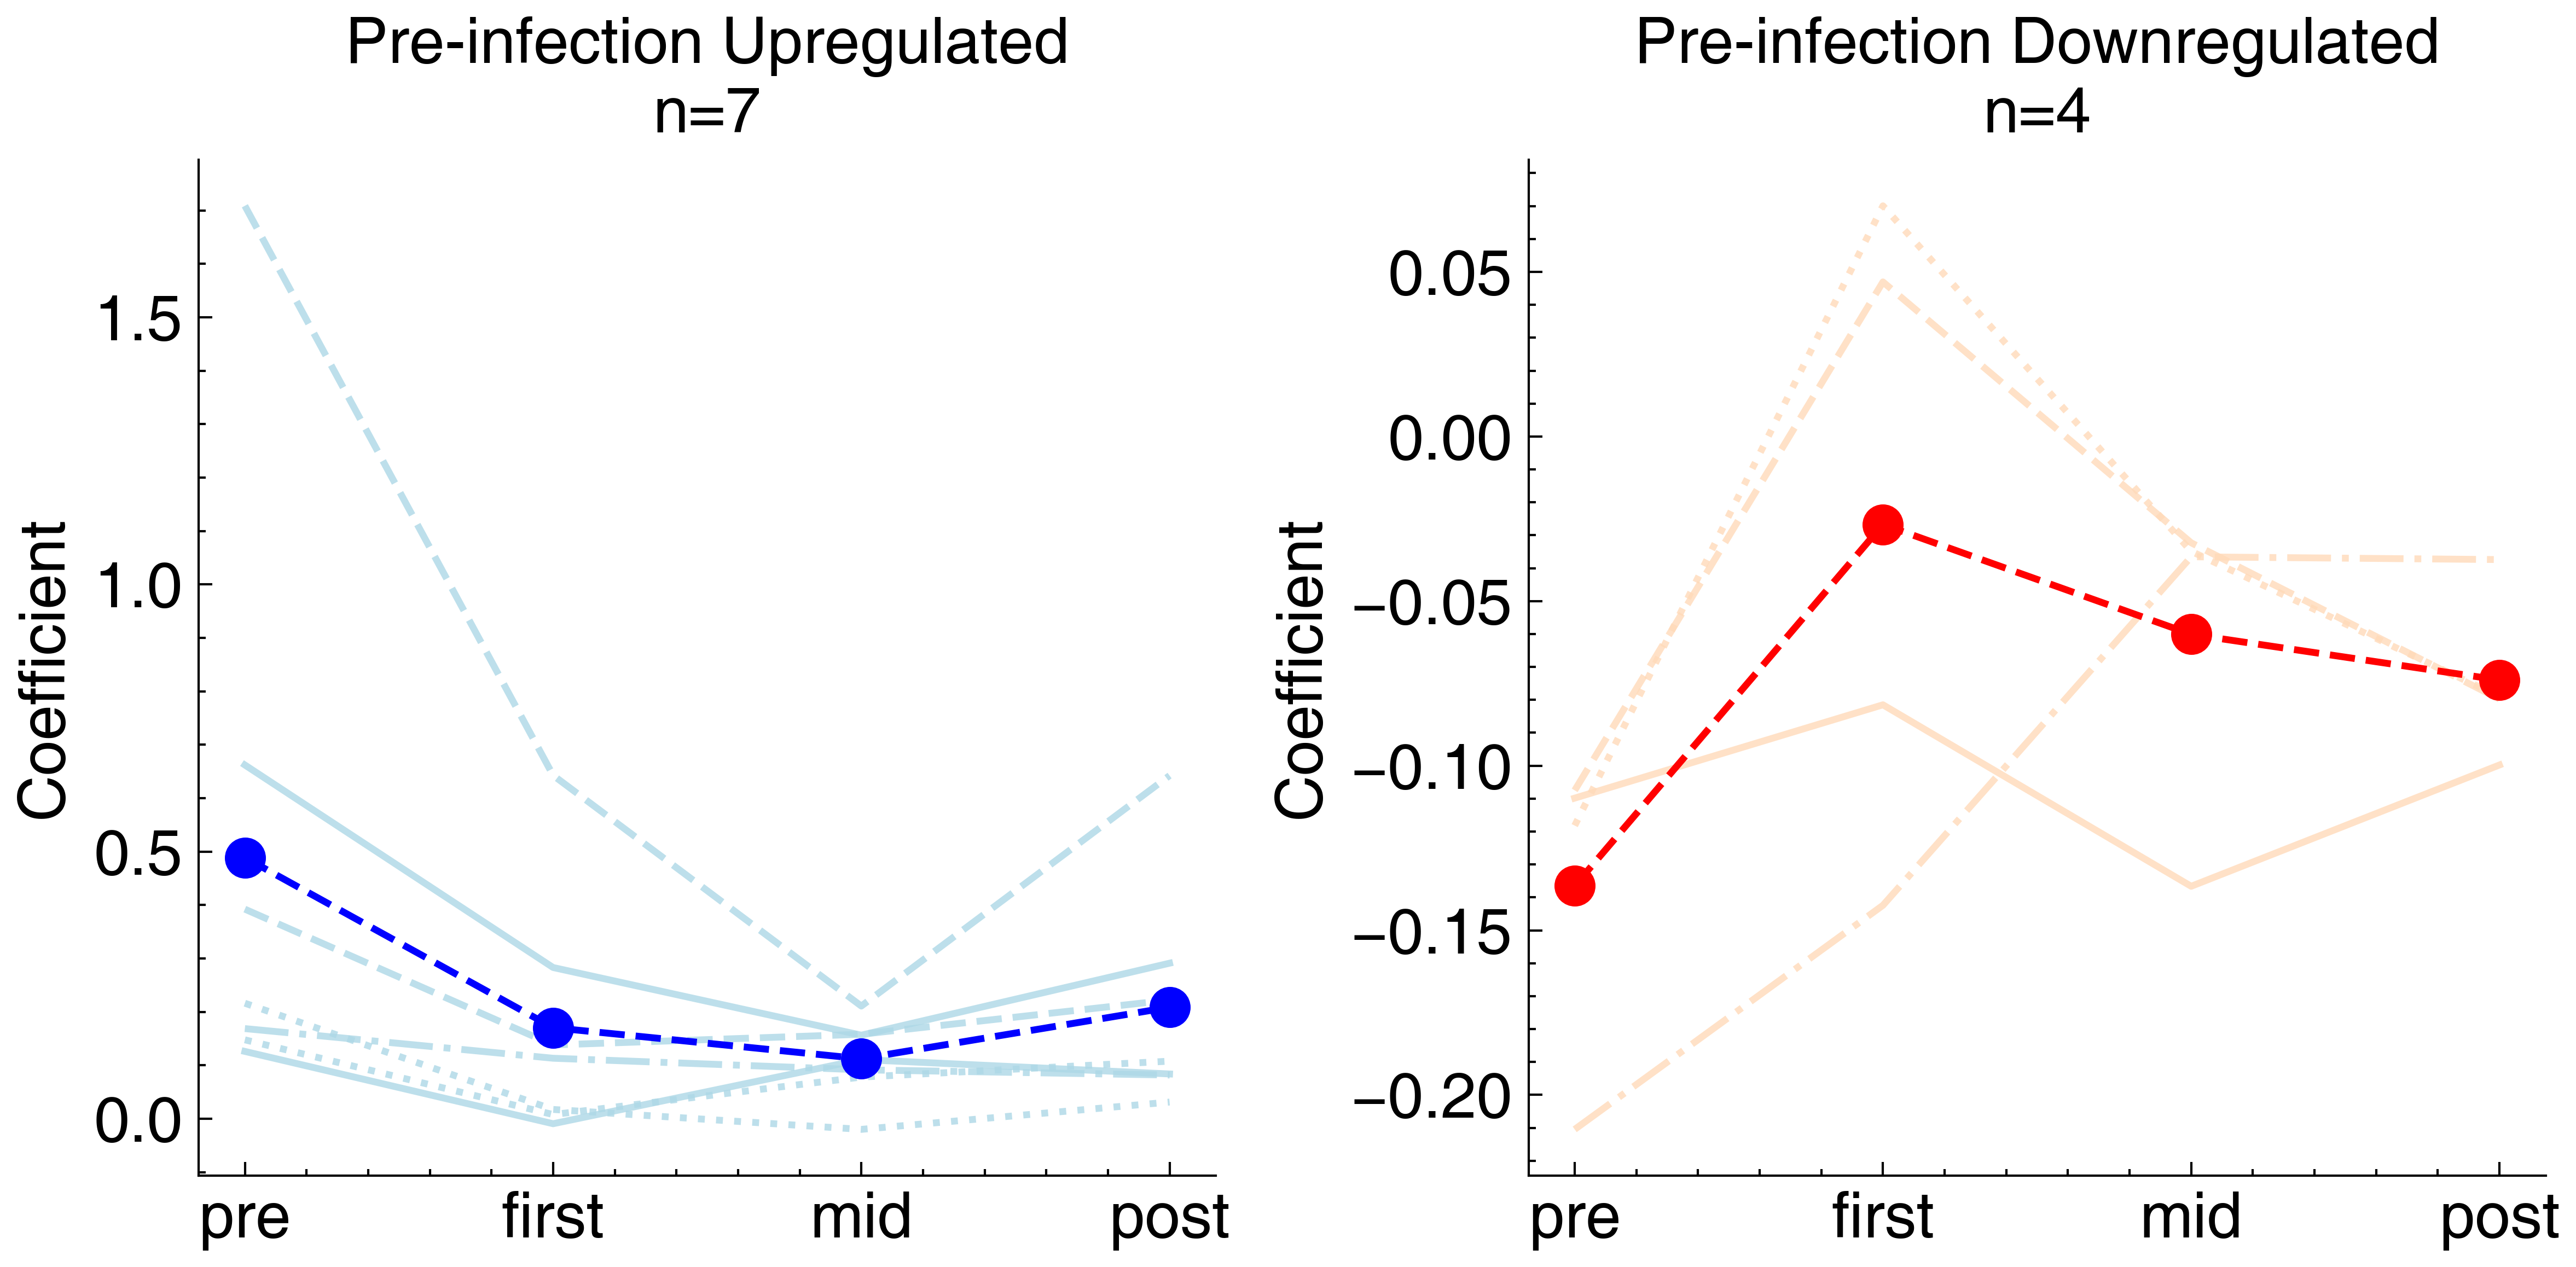

In [43]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
if up_lt_df.shape[0]:
    up_lt_df.transpose().plot(color='lightblue', alpha=0.8, ax=axs[0])
    axs[0].get_legend().remove()
    axs[0].set_ylabel('Coefficient')
    axs[0].plot(up_lt_df.mean(axis=0), color='blue', linestyle='--', marker='o')
    axs[0].set_title('Pre-infection Upregulated\nn=%i'%up_lt_df.shape[0])

if dn_lt_df.shape[0]:
    dn_lt_df.transpose().plot(color='peachpuff', alpha=0.8, ax=axs[1])
    axs[1].get_legend().remove()
    axs[1].set_ylabel('Coefficient')
    #axs[1].plot(dn_lt_df.median(axis=0), color='orange', linestyle='--', marker='o')
    axs[1].plot(dn_lt_df.mean(axis=0), color='red', linestyle='--', marker='o')
    #axs[1].axhline(0, color='blue', alpha=0.75)
    axs[1].set_title('Pre-infection Downregulated\nn=%i'%dn_lt_df.shape[0])
fig.tight_layout()
fig.savefig('%s/10-pre_longitudinal_traj.pdf' % FIGDIR)

Use all events as a positive control:

In [44]:
# Assemble the data frame for High-confidence events (eids)
hc_ltd_df = pd.DataFrame({
    'pre': jem.stats_sheet['final@Pre'].loc[das_eids, 'coefs'],
    'first': jem.stats_sheet['final@First'].loc[das_eids, 'coefs'],
    'mid': jem.stats_sheet['final@Mid'].loc[das_eids, 'coefs'],
    'post': jem.stats_sheet['final@Post'].loc[das_eids, 'coefs'],
})
hc_up = hc_ltd_df.loc[[e for e in hc_ltd_df.index if e in up_catelog]]
hc_dn = hc_ltd_df.loc[[e for e in hc_ltd_df.index if e in dn_catelog]]

In [45]:
idx = np.where(hc_dn['first'].abs() < 1e-2)[0]
hc_dn.iloc[idx]

pre    first      mid  \
chr22:+:44726634:44731729:44726634:44731734 -0.15980 -0.00286 -0.15679   
chr17:-:81914530:81914603:81914504:81914603 -0.05745 -0.00242 -0.00054   
chr19:+:49464762:49465737:49464762:49465780 -0.07489 -0.00878 -0.03319   
chr1:+:1624901:1624964:1624901:1624990      -0.08742  0.00399 -0.04151   
chr1:-:21729832:21736445:21729829:21736445  -0.32175  0.00910 -0.05766   

                                                post  
chr22:+:44726634:44731729:44726634:44731734 -0.09549  
chr17:-:81914530:81914603:81914504:81914603 -0.08747  
chr19:+:49464762:49465737:49464762:49465780 -0.08392  
chr1:+:1624901:1624964:1624901:1624990      -0.09569  
chr1:-:21729832:21736445:21729829:21736445  -0.19562

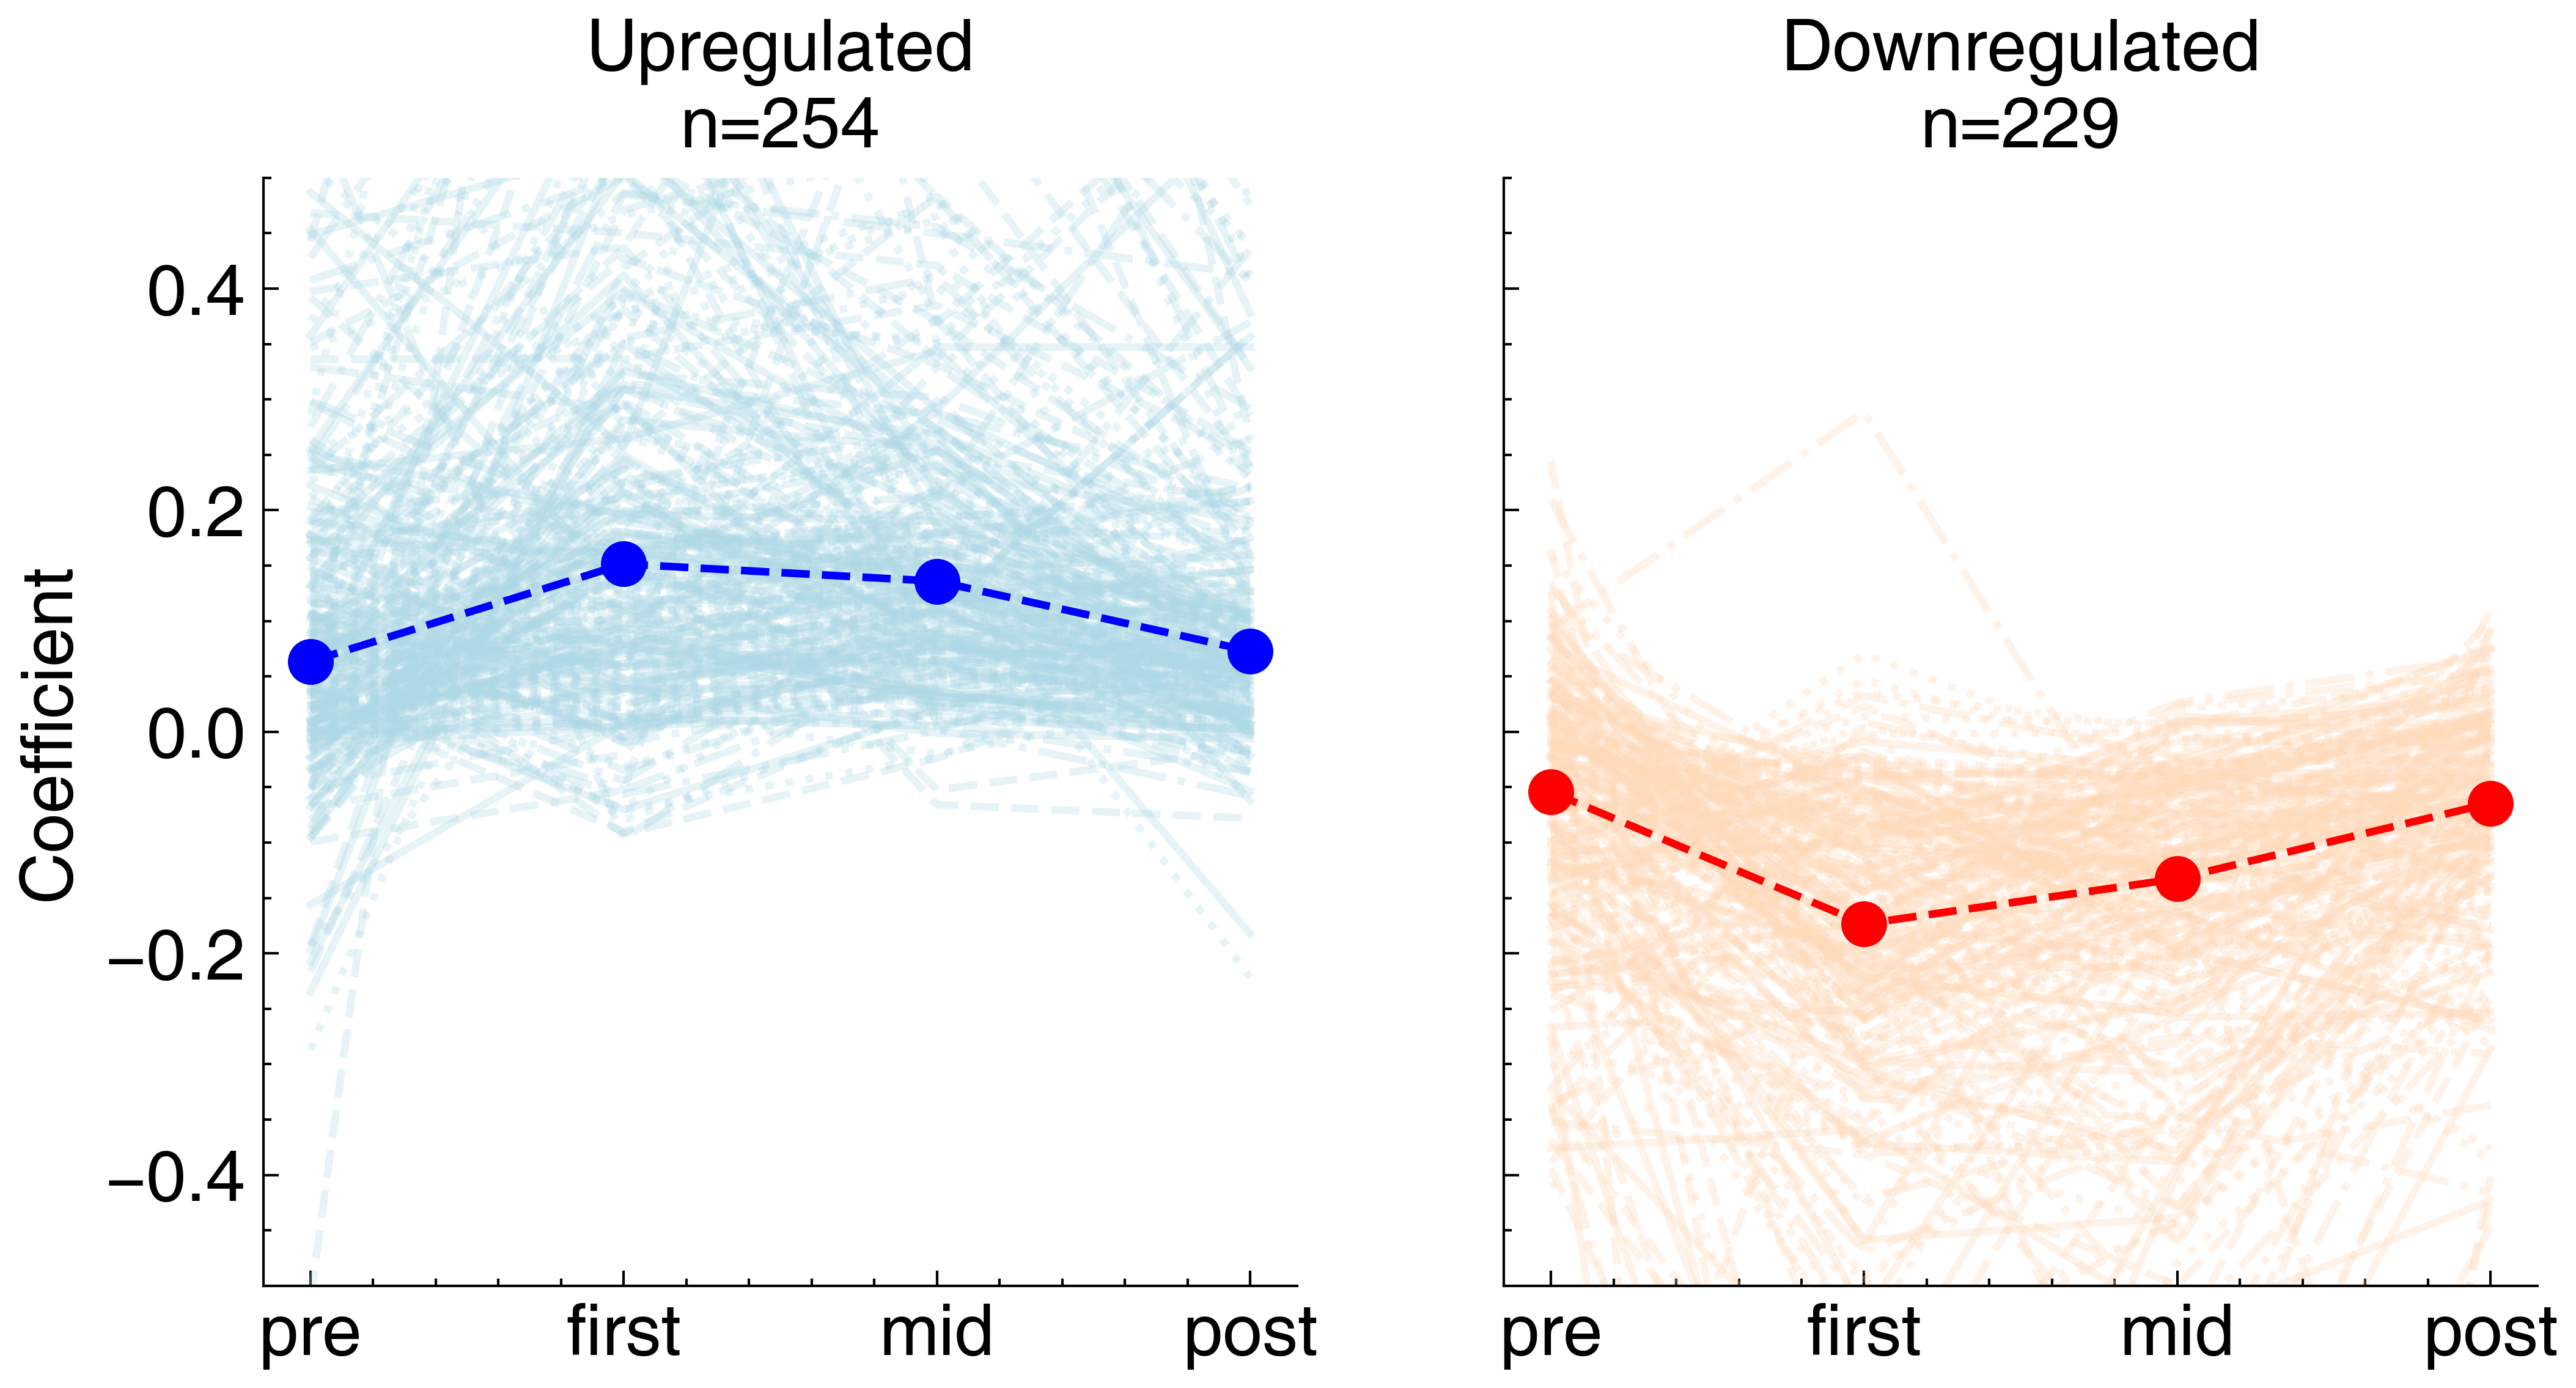

In [46]:
# Plot each event as a line, and the average trend across all events
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
#fig.suptitle("%s: High-confidence DAS events" % EVENT_TYPE)
hc_up.transpose().plot(color='lightblue', alpha=0.3, ax=axs[0])
ranges = hc_up.apply(lambda x: np.percentile(x, [25, 75]), 0)
#axs[0].fill_between([0,1,2,3], ranges.iloc[0], ranges.iloc[1], color='cornflowerblue', alpha=0.3)
#hc_up.plot(kind='box', ax=axs[0])
#axs[0].plot([1,2,3,4], hc_up.mean(axis=0), color='red', linestyle='--', marker='o')
#axs[0].axhline(0, color='blue', alpha=0.75)
axs[0].get_legend().remove()
axs[0].set_ylabel('Coefficient')
axs[0].plot(np.array([1,2,3,4]) - 1, hc_up.median(axis=0), color='blue', linestyle='--', marker='o')
axs[0].set_title("Upregulated\nn=%i"%hc_up.shape[0])
axs[0].set_ylim(-0.5,0.5)

hc_dn.transpose().plot(color='peachpuff', alpha=0.3, ax=axs[1])
ranges = hc_dn.apply(lambda x: np.percentile(x, [25, 75]), 0)
#axs[1].fill_between([0,1,2,3], ranges.iloc[0], ranges.iloc[1], color='pink', alpha=0.3)
#hc_dn.plot(kind='box', ax=axs[1])
#axs[1].plot([1,2,3,4], hc_dn.mean(axis=0), color='red', linestyle='--', marker='o')
#axs[1].axhline(0, color='blue', alpha=0.75)
#axs[1].set_ylim(-1,1)
axs[1].get_legend().remove()
axs[1].set_ylabel('Coefficient')
axs[1].plot(np.array([1,2,3,4]) -1 , hc_dn.median(axis=0), color='red', linestyle='--', marker='o')
axs[1].set_title("Downregulated\nn=%i"%hc_dn.shape[0])
fig.savefig('%s/10-longitudinal_trajs.pdf' % FIGDIR )

In [47]:
print("FINISH:", datetime.now())

FINISH: 2021-03-29 15:22:36.554977
